# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# Global variables
global alpha
global train_step

alpha = 0.
train_step = 0.

In [7]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

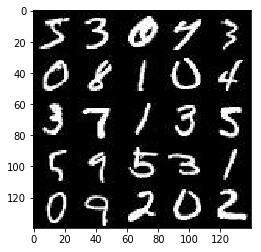

In [8]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

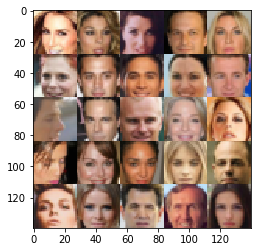

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [11]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_imgs = tf.placeholder(dtype=tf.float32, 
                               shape=[None, image_height, image_width, image_channels], 
                               name='real_imgs')
    z_input = tf.placeholder(dtype=tf.float32, shape=[None, z_dim])
    l_rate = tf.placeholder(dtype=tf.float32, shape=(), name='l_rate')
    return real_imgs, z_input, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
import numpy as np
# tf.contrib.layers.xavier_initializer
def discriminator(images, reuse=False, is_train=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    global alpha
    global train_step
    
    with tf.variable_scope('discriminator', reuse=reuse):
        def gaussian_noise_layer(input_layer, std, is_train):
            global train_step
            
            if is_train:
                stddev = np.clip(std/np.sqrt(train_step + 1.), 0., std)
                noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=stddev, dtype=tf.float32)
                return input_layer + noise
            else:
                return input_layer
        
        # Add noise to input
        images = gaussian_noise_layer(images, 0.2, is_train)
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, 
                              kernel_initializer= tf.contrib.layers.xavier_initializer(),
                              strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate = 0.5, training=is_train)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 
                              kernel_initializer= tf.contrib.layers.xavier_initializer(),
                              kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate = 0.5, training=is_train)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 
                              kernel_initializer= tf.contrib.layers.xavier_initializer(),
                              kernel_size=3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate = 0.5, training=is_train)
        # 1x1x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [66]:
def gaussian_noise_layer(input_layer, std, is_train):
    global train_step

    if is_train:
        stddev = np.clip(std/np.sqrt(train_step + 1.), 0., std)
        noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=stddev, dtype=tf.float32)
        return input_layer + noise
    else:
        return input_layer
        
        
def nn_upsample(x, out_chan, size, ks=3, is_train = False, batch_norm = True):
    '''
    Upsample using NN followed by a detailing 2D convolution
    '''
    global alpha
    x = tf.image.resize_nearest_neighbor(x, size=size)
    if batch_norm:
        x = tf.layers.batch_normalization(x, training=is_train)
        
    x = tf.layers.conv2d(x, out_chan, 
                         kernel_initializer= tf.contrib.layers.xavier_initializer(),
                         kernel_size=ks, strides = 1, padding='same')
    if batch_norm:
        x = tf.layers.batch_normalization(x, training=is_train)
    x = tf.maximum(alpha * x, x)
    return x


def T_conv2d_upsample(x, out_chan, ks=4, s=2, is_train = False, batch_norm = True):
    global alpha
    x = tf.layers.conv2d_transpose(x, out_chan,
                                   kernel_initializer= tf.contrib.layers.xavier_initializer(),
                                   kernel_size=ks, strides=s, padding='same')
    if batch_norm:
        x = tf.layers.batch_normalization(x, training=is_train)
    x = tf.maximum(alpha * x, x)
    return x


def T_conv2d_conv2d_upsample(x, out_chan, ks=4, s=2, is_train = False, batch_norm = True):
    global alpha
    
    # Transpose convolution
    x = tf.layers.conv2d_transpose(x, 256,
                                   kernel_initializer= tf.contrib.layers.xavier_initializer(),
                                   kernel_size=ks, strides=s, padding='same')
    if batch_norm:
        x = tf.layers.batch_normalization(x, training=is_train)
    x = tf.maximum(alpha * x, x)
    
    # Smoothing conv. Keep the same spatial dim.
    x = tf.layers.conv2d(x, out_chan, 
                         kernel_initializer= tf.contrib.layers.xavier_initializer(),
                         kernel_size=3, strides=1, padding='same')
    if batch_norm:
        x = tf.layers.batch_normalization(x, training=is_train)
    x = tf.maximum(alpha * x, x)
    
    return x


def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    global alpha
    global train_step
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # Zero padding to avoid checker-box artifacts
        # First fully connected layer
        fc_chan = 128
        x1 = tf.layers.dense(z,7*7*fc_chan, kernel_initializer= tf.contrib.layers.xavier_initializer())
        
        
        # ------------ Layer 1 ------------------#
        ks1 = 2
        s1 = 2
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, fc_chan))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = gaussian_noise_layer(x1, 0.05, is_train)
        # batch_size x 7 x 7 x fc_chan
        
        
        
        # ------------- Layer 2 --------------------
        # Zero-pad to avoid edge artifacts
        x1 = tf.pad(x1, paddings=[
                                  [0, 0],  # No padding along the batch dimesion 
                                  [ks1-s1+1, ks1-s1+1], # Pad along H
                                  [ks1-s1+1, ks1-s1+1], # Pad along W
                                  [0, 0]  # No pad along chanel
                                 ])
        
        # batch_size x (7 + ks1-s1) x (7 + ks1-s1) x fc_chan
        ks2 = 2
        s2 = 2
        l3_chan = 64
        
#         x2 = nn_upsample(x1, out_chan=l3_chan, size=((14 + s2*(2*(ks1-s1+1))), (14 + s2*(2*(ks1-s1+1)))), 
#                          ks=3, is_train = is_train)
    
        x2 = T_conv2d_conv2d_upsample(x1, out_chan=l3_chan, ks=ks2, s=s2, is_train = is_train)
        # batch_size x (14 + 2*(ks1-s1)) x (14 + 2*(ks1-s1)) x 32
        
        # Trim to remove noise in the edges introduced by previous zero-padding
        x2 = x2[:, s2*(ks1-s1+1):-s2*(ks1-s1+1), s2*(ks1-s1+1):-s2*(ks1-s1+1), :]
        
        
        x2 = gaussian_noise_layer(x2, 0.05, is_train)
        # batch_size x 14 x 14 x 32
        
        
        # ------------- Layer 3 --------------------
        # Zero-pad to avoid edge artifacts
        x2 = tf.pad(x2, paddings=[
                                  [0, 0],  # No padding along the batch dimesion 
                                  [ks2-s2+1, ks2-s2+1], # Pad along H
                                  [ks2-s2+1, ks2-s2+1], # Pad along W
                                  [0, 0]  # No pad along chanel
                                 ])
        # batch_size x (14 + ks2-s2) x (14 + ks2-s2) x 32
        ks3 = 2
        s3 = 2
#         logits = nn_upsample(x2, out_chan=out_channel_dim, size=(28, 28), ks=5, 
#                              is_train = is_train, batch_norm=False)
        # Do not batch_normalize the output logits
        logits = T_conv2d_upsample(x2, out_chan=out_channel_dim, 
                                   ks=ks3, s=s3, is_train = is_train, batch_norm=False)
        # batch_size x (28 + s3*(ks2-s2)) x (28 + s3*(ks2-s2)) x 32
        
        # Trim. Note: [batch, h, w, channel]
        logits = logits[:, s3*(ks2-s2+1):-s3*(ks2-s2+1), s3*(ks2-s2+1):-s3*(ks2-s2+1), :]
        # batch_size x 28 x 28 x out_channel_dim
        
        
        # ------------ Output Layer -------------------
        out = tf.tanh(logits)
        # batch_size x 28 x 28 x out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [67]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, is_train=True)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, is_train=True)

    # -------------- #
    d_logits_real_labels_noised = tf.random_uniform(shape = tf.shape(d_model_real), minval = 0.9, maxval = 1.2)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=d_logits_real_labels_noised))
    
    d_logits_fake_labels_noised = tf.random_uniform(shape = tf.shape(d_model_fake), minval = 0.0, maxval = 0.2)
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=d_logits_fake_labels_noised))
    
    # ------------- #
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

#     d_loss = tf.reduce_mean(d_logits_real - d_logits_fake)
#     g_loss = tf.reduce_mean(d_logits_fake)
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [68]:
def get_gradients(opt, loss, var_list):
    grads_and_vars = opt.compute_gradients(loss=loss, var_list=var_list)
    grads = [g for g, _ in grads_and_vars]
    print('Length of gradients: {}'.format(len(grads)))
    return grads
    

def model_opt(d_loss, g_loss, learning_rate, beta1, **kwargs):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1)
        for key in kwargs:
            if key == 'd_grads':
                d_grads = get_gradients(d_optimizer, d_loss, d_vars)
                kwargs[key].append(d_grads)
            elif key == 'g_grads':
                g_grads = get_gradients(g_optimizer, g_loss, g_vars)
                kwargs[key].append(g_grads)
        
        d_train_opt = d_optimizer.minimize(d_loss, var_list=d_vars)
        g_train_opt = g_optimizer.minimize(g_loss, var_list=g_vars)
        
        

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    # example_z = np.random.normal(0., 1., size=(n_images, z_dim))

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [70]:
from numpy.linalg import norm
from numpy import mean
from numpy import std


def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    global train_step
    
    print_every=20
    show_every=40
    learning_rate_init = learning_rate
    
    image_height, image_width = data_shape[1], data_shape[2]
    if data_image_mode == 'RGB':
        image_channels = 3
    elif data_image_mode == 'L':
        image_channels = 1
    else:
        raise Exception('Incorrect "data_image_mode"')
    
    d_grads = []
    g_grads = []
    real_imgs, z_input, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real_imgs, z_input, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_rate, beta1, d_grads=d_grads, g_grads=g_grads)
    
    samples, losses = [], []
    train_step = 0
    img_cnt = 0
    D_grad_norm, D_grad_mean, D_grad_std = 1., 1., 1.
    G_grad_norm, G_grad_mean, G_grad_std = 1., 1., 1.
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                train_step += 1
                if train_step <= 300:
                    learning_rate = learning_rate_init
                elif (train_step > 300) and (train_step <= 1000):
                    learning_rate = learning_rate_init/10.
                elif (train_step > 1000):
                    learning_rate = learning_rate_init/100.
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # batch_z = np.random.normal(0., 1., size=(batch_size, z_dim))
                
                # Run optimizers
                _= sess.run(d_train_opt, feed_dict={real_imgs: batch_images, 
                                                    z_input: batch_z, 
                                                    l_rate: learning_rate})
                _= sess.run(g_train_opt,feed_dict={real_imgs: batch_images, 
                                                   z_input: batch_z, 
                                                   l_rate: 2.*learning_rate})
                   
                d_grad_list, g_grad_list = sess.run([d_grads[0], g_grads[0]], feed_dict={real_imgs: batch_images, z_input: batch_z})

                d_grad_list_flat = []
                for el in d_grad_list:
                    el = np.reshape(el, newshape=-1)
                    d_grad_list_flat.extend(el)
                d_grad_list = np.array(d_grad_list_flat)
                D_grad_norm = float(norm(d_grad_list))
                D_grad_mean = float(mean(d_grad_list))
                D_grad_std = float(std(d_grad_list))
                
                d_grad_list_abs = np.abs(d_grad_list)
                D_grad_min_abs = float(np.min(d_grad_list_abs))
                D_grad_max_abs = float(np.max(d_grad_list_abs))
                
                g_grad_list_flat = []
                for el in g_grad_list:
                    el = np.reshape(el, newshape=-1)
                    g_grad_list_flat.extend(el)
                    
                g_grad_list = np.array(g_grad_list_flat)
                g_grad_list_abs = np.abs(g_grad_list)
                G_grad_norm = float(norm(g_grad_list))
                G_grad_mean = float(mean(g_grad_list))
                G_grad_std =  float(std(g_grad_list))
                G_grad_min_abs = float(np.min(g_grad_list_abs))
                G_grad_max_abs = float(np.max(g_grad_list_abs))
            
                
                if train_step % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_imgs: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    print('--------------------------------------------------------')
                    print('Train Step: {}'.format(train_step))
                    print('Batch Size: {}, Learning Rate: {}'.format(batch_images.shape[0], learning_rate))
                    print('D_Grad - Norm: {0:.5e}, Max |Grad|: {1:.5e}, Min |Grad|: {2:.5e}, Mean: {3:.5e}, Std: {4:.5e}'.format(
                        D_grad_norm, 
                        D_grad_max_abs, 
                        D_grad_min_abs, 
                        D_grad_mean, 
                        D_grad_std))
                    
                    print('G_Grad - Norm: {0:.5e},  Max |Grad|: {1:.5e}, Min |Grad|: {2:.5e}, Mean: {3:.5e}, Std: {4:.5e}'.format(
                        G_grad_norm,
                        G_grad_max_abs,
                        G_grad_min_abs,
                        G_grad_mean, 
                        G_grad_std))
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if train_step % show_every == 0:
                    img_cnt+=1
                    print('Image: {}'.format(img_cnt))
                    show_generator_output(sess, n_images=25, input_z=z_input, 
                                          out_channel_dim=image_channels, 
                                          image_mode=data_image_mode)
        
        show_generator_output(sess, n_images=25, input_z=z_input, out_channel_dim=image_channels, image_mode=data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Length of gradients: 12
Length of gradients: 14
--------------------------------------------------------
Train Step: 20
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 4.58475e-01, Max |Grad|: 8.72516e-02, Min |Grad|: 1.07292e-12, Mean: 2.04107e-05, Std: 6.46268e-04
G_Grad - Norm: 7.92337e-02,  Max |Grad|: 7.66176e-03, Min |Grad|: 0.00000e+00, Mean: -6.73420e-07, Std: 8.28989e-05
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.5021
--------------------------------------------------------
Train Step: 40
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 4.26126e-01, Max |Grad|: 7.68567e-02, Min |Grad|: 9.98313e-13, Mean: -6.71250e-06, Std: 6.00948e-04
G_Grad - Norm: 9.52507e-02,  Max |Grad|: 2.58326e-02, Min |Grad|: 0.00000e+00, Mean: 2.06718e-06, Std: 9.96385e-05
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.5626
Image: 1


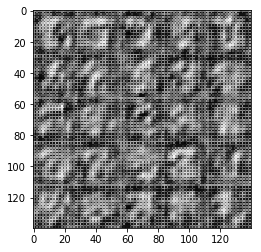

--------------------------------------------------------
Train Step: 60
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 4.50779e-01, Max |Grad|: 5.31864e-02, Min |Grad|: 9.80549e-13, Mean: -3.69404e-06, Std: 6.35736e-04
G_Grad - Norm: 7.00784e-02,  Max |Grad|: 1.08020e-02, Min |Grad|: 0.00000e+00, Mean: 2.39781e-06, Std: 7.32831e-05
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.5777
--------------------------------------------------------
Train Step: 80
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 6.84900e-01, Max |Grad|: 8.11102e-02, Min |Grad|: 1.02318e-12, Mean: -2.74957e-05, Std: 9.65579e-04
G_Grad - Norm: 6.26084e-02,  Max |Grad|: 2.69764e-03, Min |Grad|: 0.00000e+00, Mean: 2.66961e-07, Std: 6.55063e-05
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.5992
Image: 2


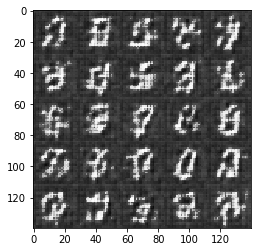

--------------------------------------------------------
Train Step: 100
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 1.10436e+00, Max |Grad|: 1.32596e-01, Min |Grad|: 0.00000e+00, Mean: 5.35045e-05, Std: 1.55705e-03
G_Grad - Norm: 9.44988e-02,  Max |Grad|: 1.58301e-02, Min |Grad|: 0.00000e+00, Mean: 1.40472e-06, Std: 9.88631e-05
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.5714
--------------------------------------------------------
Train Step: 120
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 7.44579e-01, Max |Grad|: 7.70840e-02, Min |Grad|: 2.84217e-13, Mean: -1.00434e-06, Std: 1.05025e-03
G_Grad - Norm: 5.51132e-02,  Max |Grad|: 5.07719e-03, Min |Grad|: 1.36424e-12, Mean: -5.76000e-07, Std: 5.76619e-05
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.5317
Image: 3


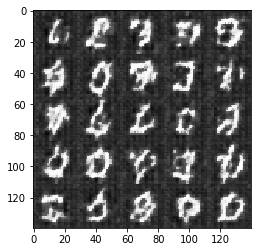

--------------------------------------------------------
Train Step: 140
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 1.07969e+00, Max |Grad|: 1.05246e-01, Min |Grad|: 0.00000e+00, Mean: -4.49651e-05, Std: 1.52250e-03
G_Grad - Norm: 6.37329e-02,  Max |Grad|: 4.37230e-03, Min |Grad|: 0.00000e+00, Mean: 8.43633e-07, Std: 6.66779e-05
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.5887
--------------------------------------------------------
Train Step: 160
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 6.14830e-01, Max |Grad|: 8.46946e-02, Min |Grad|: 0.00000e+00, Mean: 5.16041e-06, Std: 8.67162e-04
G_Grad - Norm: 6.71017e-02,  Max |Grad|: 7.35195e-03, Min |Grad|: 0.00000e+00, Mean: -2.96170e-07, Std: 7.02072e-05
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.6147
Image: 4


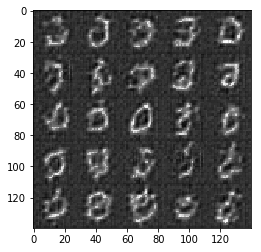

--------------------------------------------------------
Train Step: 180
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 8.69469e-01, Max |Grad|: 1.55394e-01, Min |Grad|: 1.93268e-12, Mean: -1.46140e-05, Std: 1.22637e-03
G_Grad - Norm: 6.48617e-02,  Max |Grad|: 1.16215e-02, Min |Grad|: 0.00000e+00, Mean: 2.95049e-07, Std: 6.78635e-05
Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 0.6223
--------------------------------------------------------
Train Step: 200
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 8.20807e-01, Max |Grad|: 9.26570e-02, Min |Grad|: 8.52651e-14, Mean: 6.27545e-06, Std: 1.15781e-03
G_Grad - Norm: 6.48570e-02,  Max |Grad|: 2.63688e-02, Min |Grad|: 0.00000e+00, Mean: 3.22557e-07, Std: 6.78587e-05
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.6419
Image: 5


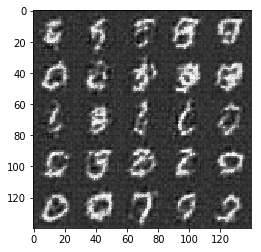

--------------------------------------------------------
Train Step: 220
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 5.04954e-01, Max |Grad|: 9.22214e-02, Min |Grad|: 0.00000e+00, Mean: 9.98043e-06, Std: 7.12174e-04
G_Grad - Norm: 7.26566e-02,  Max |Grad|: 1.88941e-02, Min |Grad|: 0.00000e+00, Mean: -1.11106e-06, Std: 7.60118e-05
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.6169
--------------------------------------------------------
Train Step: 240
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 9.63523e-01, Max |Grad|: 1.30498e-01, Min |Grad|: 0.00000e+00, Mean: -2.48590e-05, Std: 1.35887e-03
G_Grad - Norm: 6.63006e-02,  Max |Grad|: 5.85848e-03, Min |Grad|: 0.00000e+00, Mean: -1.18232e-06, Std: 6.93599e-05
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.6365
Image: 6


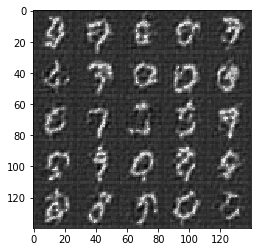

--------------------------------------------------------
Train Step: 260
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 9.62162e-01, Max |Grad|: 1.50439e-01, Min |Grad|: 0.00000e+00, Mean: 3.90923e-05, Std: 1.35658e-03
G_Grad - Norm: 8.94144e-02,  Max |Grad|: 2.04328e-02, Min |Grad|: 0.00000e+00, Mean: 1.40254e-06, Std: 9.35425e-05
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.6178
--------------------------------------------------------
Train Step: 280
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 1.12128e+00, Max |Grad|: 1.69459e-01, Min |Grad|: 9.59233e-14, Mean: -3.59858e-06, Std: 1.58192e-03
G_Grad - Norm: 6.00947e-02,  Max |Grad|: 1.14594e-02, Min |Grad|: 0.00000e+00, Mean: -2.58176e-07, Std: 6.28759e-05
Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.6377
Image: 7


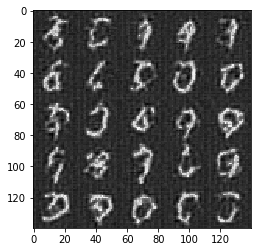

--------------------------------------------------------
Train Step: 300
Batch Size: 64, Learning Rate: 0.001
D_Grad - Norm: 1.29760e+00, Max |Grad|: 1.35863e-01, Min |Grad|: 0.00000e+00, Mean: 3.81347e-05, Std: 1.83002e-03
G_Grad - Norm: 1.63758e-01,  Max |Grad|: 7.12922e-02, Min |Grad|: 0.00000e+00, Mean: -1.95762e-06, Std: 1.71327e-04
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.5652
--------------------------------------------------------
Train Step: 320
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 3.94638e-01, Max |Grad|: 4.39147e-02, Min |Grad|: 0.00000e+00, Mean: 8.71636e-06, Std: 5.56504e-04
G_Grad - Norm: 9.21935e-02,  Max |Grad|: 1.49899e-02, Min |Grad|: 0.00000e+00, Mean: -1.02488e-06, Std: 9.64557e-05
Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.6011
Image: 8


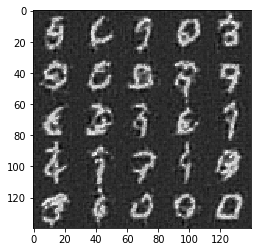

--------------------------------------------------------
Train Step: 340
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 4.48261e-01, Max |Grad|: 8.52650e-02, Min |Grad|: 1.81899e-12, Mean: 1.19356e-06, Std: 6.32195e-04
G_Grad - Norm: 8.81932e-02,  Max |Grad|: 1.83482e-02, Min |Grad|: 0.00000e+00, Mean: 3.62744e-07, Std: 9.22752e-05
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.6031
--------------------------------------------------------
Train Step: 360
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 4.47377e-01, Max |Grad|: 7.63479e-02, Min |Grad|: 0.00000e+00, Mean: 8.47675e-06, Std: 6.30894e-04
G_Grad - Norm: 8.85797e-02,  Max |Grad|: 1.10162e-02, Min |Grad|: 0.00000e+00, Mean: 5.81627e-08, Std: 9.26798e-05
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.6054
Image: 9


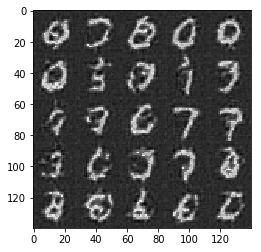

--------------------------------------------------------
Train Step: 380
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 3.88711e-01, Max |Grad|: 5.17261e-02, Min |Grad|: 3.80851e-12, Mean: 3.72880e-06, Std: 5.48203e-04
G_Grad - Norm: 9.05864e-02,  Max |Grad|: 1.16764e-02, Min |Grad|: 0.00000e+00, Mean: -5.71809e-07, Std: 9.47780e-05
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.6085
--------------------------------------------------------
Train Step: 400
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 5.56288e-01, Max |Grad|: 7.14578e-02, Min |Grad|: 4.83169e-13, Mean: 2.61217e-06, Std: 7.84605e-04
G_Grad - Norm: 8.85669e-02,  Max |Grad|: 1.06495e-02, Min |Grad|: 1.50635e-12, Mean: -4.18401e-07, Std: 9.26655e-05
Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.6079
Image: 10


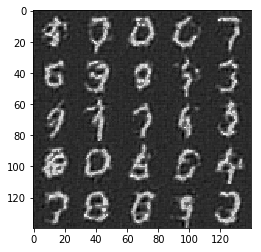

--------------------------------------------------------
Train Step: 420
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 5.28644e-01, Max |Grad|: 6.71864e-02, Min |Grad|: 0.00000e+00, Mean: -1.18779e-07, Std: 7.45619e-04
G_Grad - Norm: 1.00113e-01,  Max |Grad|: 1.52824e-02, Min |Grad|: 0.00000e+00, Mean: -2.46905e-07, Std: 1.04747e-04
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 0.5980
--------------------------------------------------------
Train Step: 440
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 4.93894e-01, Max |Grad|: 5.81191e-02, Min |Grad|: 1.02318e-12, Mean: -5.90886e-06, Std: 6.96523e-04
G_Grad - Norm: 1.00341e-01,  Max |Grad|: 1.34051e-02, Min |Grad|: 0.00000e+00, Mean: 5.38438e-07, Std: 1.04985e-04
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 0.6042
Image: 11


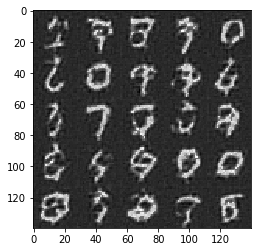

--------------------------------------------------------
Train Step: 460
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 4.80791e-01, Max |Grad|: 7.65692e-02, Min |Grad|: 5.91172e-12, Mean: 3.94633e-06, Std: 6.78058e-04
G_Grad - Norm: 1.00160e-01,  Max |Grad|: 1.48803e-02, Min |Grad|: 9.09495e-13, Mean: 8.49777e-07, Std: 1.04793e-04
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.6000
--------------------------------------------------------
Train Step: 480
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 5.06712e-01, Max |Grad|: 6.98521e-02, Min |Grad|: 0.00000e+00, Mean: 3.33068e-06, Std: 7.14684e-04
G_Grad - Norm: 1.09317e-01,  Max |Grad|: 1.55874e-02, Min |Grad|: 1.81899e-12, Mean: -2.56067e-07, Std: 1.14378e-04
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.5967
Image: 12


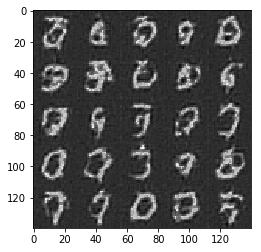

--------------------------------------------------------
Train Step: 500
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 4.42069e-01, Max |Grad|: 4.35528e-02, Min |Grad|: 8.32756e-12, Mean: 8.83545e-06, Std: 6.23397e-04
G_Grad - Norm: 9.78049e-02,  Max |Grad|: 1.64425e-02, Min |Grad|: 0.00000e+00, Mean: -1.05114e-06, Std: 1.02328e-04
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.5991
--------------------------------------------------------
Train Step: 520
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 4.25206e-01, Max |Grad|: 6.49676e-02, Min |Grad|: 1.81899e-12, Mean: -4.44829e-06, Std: 5.99660e-04
G_Grad - Norm: 1.00676e-01,  Max |Grad|: 1.50223e-02, Min |Grad|: 0.00000e+00, Mean: 7.51472e-07, Std: 1.05334e-04
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.6111
Image: 13


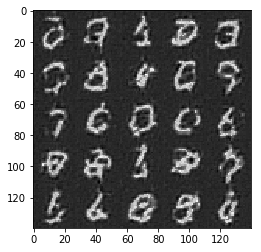

--------------------------------------------------------
Train Step: 540
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 4.94401e-01, Max |Grad|: 6.15638e-02, Min |Grad|: 3.18323e-12, Mean: -8.62803e-08, Std: 6.97260e-04
G_Grad - Norm: 1.01391e-01,  Max |Grad|: 1.38207e-02, Min |Grad|: 1.81899e-12, Mean: -4.30453e-07, Std: 1.06084e-04
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.5999
--------------------------------------------------------
Train Step: 560
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 7.24637e-01, Max |Grad|: 7.68023e-02, Min |Grad|: 0.00000e+00, Mean: 1.62356e-05, Std: 1.02210e-03
G_Grad - Norm: 1.16963e-01,  Max |Grad|: 2.99760e-02, Min |Grad|: 0.00000e+00, Mean: -7.73341e-07, Std: 1.22376e-04
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.6036
Image: 14


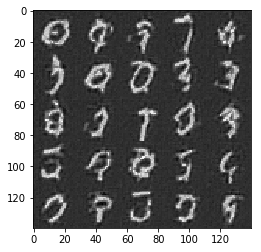

--------------------------------------------------------
Train Step: 580
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 5.24583e-01, Max |Grad|: 1.03732e-01, Min |Grad|: 7.29017e-12, Mean: -1.20572e-08, Std: 7.39882e-04
G_Grad - Norm: 1.14108e-01,  Max |Grad|: 1.16382e-02, Min |Grad|: 0.00000e+00, Mean: 1.65668e-06, Std: 1.19380e-04
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.6026
--------------------------------------------------------
Train Step: 600
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 6.01197e-01, Max |Grad|: 1.31085e-01, Min |Grad|: 0.00000e+00, Mean: 9.16142e-06, Std: 8.47872e-04
G_Grad - Norm: 1.13433e-01,  Max |Grad|: 1.18453e-02, Min |Grad|: 1.81899e-12, Mean: 5.46783e-07, Std: 1.18683e-04
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.6043
Image: 15


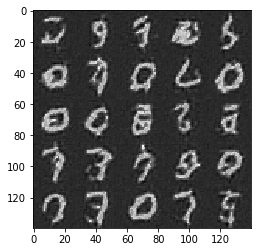

--------------------------------------------------------
Train Step: 620
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 5.94853e-01, Max |Grad|: 6.67887e-02, Min |Grad|: 9.09495e-13, Mean: 5.73460e-06, Std: 8.38957e-04
G_Grad - Norm: 1.18690e-01,  Max |Grad|: 1.90988e-02, Min |Grad|: 0.00000e+00, Mean: 4.65307e-07, Std: 1.24184e-04
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.6173
--------------------------------------------------------
Train Step: 640
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 6.38167e-01, Max |Grad|: 8.23154e-02, Min |Grad|: 1.09139e-11, Mean: -8.52845e-06, Std: 9.00018e-04
G_Grad - Norm: 1.28767e-01,  Max |Grad|: 2.90560e-02, Min |Grad|: 0.00000e+00, Mean: 1.17679e-06, Std: 1.34722e-04
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 0.6014
Image: 16


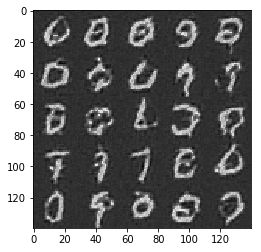

--------------------------------------------------------
Train Step: 660
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 7.92152e-01, Max |Grad|: 1.11993e-01, Min |Grad|: 0.00000e+00, Mean: -2.56334e-05, Std: 1.11711e-03
G_Grad - Norm: 1.27615e-01,  Max |Grad|: 2.30585e-02, Min |Grad|: 0.00000e+00, Mean: -4.60047e-08, Std: 1.33523e-04
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.6064
--------------------------------------------------------
Train Step: 680
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 5.48149e-01, Max |Grad|: 7.49301e-02, Min |Grad|: 1.36424e-12, Mean: -8.71389e-07, Std: 7.73101e-04
G_Grad - Norm: 1.26657e-01,  Max |Grad|: 2.34893e-02, Min |Grad|: 0.00000e+00, Mean: -6.41734e-07, Std: 1.32518e-04
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.6033
Image: 17


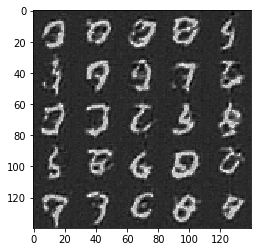

--------------------------------------------------------
Train Step: 700
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 6.81506e-01, Max |Grad|: 1.27170e-01, Min |Grad|: 0.00000e+00, Mean: -7.16419e-06, Std: 9.61142e-04
G_Grad - Norm: 1.18490e-01,  Max |Grad|: 1.63773e-02, Min |Grad|: 0.00000e+00, Mean: -1.09058e-06, Std: 1.23970e-04
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.6038
--------------------------------------------------------
Train Step: 720
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 6.28740e-01, Max |Grad|: 6.75105e-02, Min |Grad|: 1.81899e-12, Mean: 8.94310e-06, Std: 8.86708e-04
G_Grad - Norm: 1.31964e-01,  Max |Grad|: 2.41711e-02, Min |Grad|: 0.00000e+00, Mean: 7.60017e-07, Std: 1.38071e-04
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.5945
Image: 18


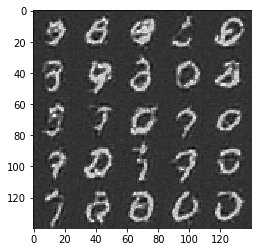

--------------------------------------------------------
Train Step: 740
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 8.76347e-01, Max |Grad|: 1.13201e-01, Min |Grad|: 0.00000e+00, Mean: -1.87731e-05, Std: 1.23597e-03
G_Grad - Norm: 1.36541e-01,  Max |Grad|: 3.07137e-02, Min |Grad|: 0.00000e+00, Mean: 5.16098e-07, Std: 1.42860e-04
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.6019
--------------------------------------------------------
Train Step: 760
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 7.43840e-01, Max |Grad|: 8.38169e-02, Min |Grad|: 1.81899e-12, Mean: 4.82416e-06, Std: 1.04926e-03
G_Grad - Norm: 1.40431e-01,  Max |Grad|: 2.87617e-02, Min |Grad|: 0.00000e+00, Mean: 4.23938e-09, Std: 1.46932e-04
Epoch 1/2... Discriminator Loss: 1.3271... Generator Loss: 0.5962
Image: 19


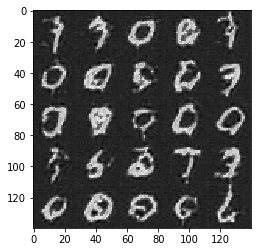

--------------------------------------------------------
Train Step: 780
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 7.64960e-01, Max |Grad|: 1.12468e-01, Min |Grad|: 1.81899e-12, Mean: 1.03926e-05, Std: 1.07900e-03
G_Grad - Norm: 1.25062e-01,  Max |Grad|: 1.70884e-02, Min |Grad|: 0.00000e+00, Mean: -5.52581e-07, Std: 1.30850e-04
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.6034
--------------------------------------------------------
Train Step: 800
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 1.28654e+00, Max |Grad|: 1.65517e-01, Min |Grad|: 8.18545e-12, Mean: 1.87167e-05, Std: 1.81478e-03
G_Grad - Norm: 1.44440e-01,  Max |Grad|: 1.58531e-02, Min |Grad|: 0.00000e+00, Mean: -9.87151e-08, Std: 1.51125e-04
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.5920
Image: 20


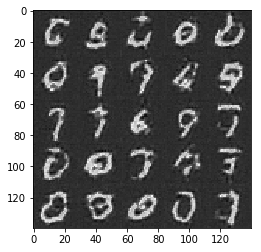

--------------------------------------------------------
Train Step: 820
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 6.25273e-01, Max |Grad|: 8.45127e-02, Min |Grad|: 0.00000e+00, Mean: -7.39217e-06, Std: 8.81828e-04
G_Grad - Norm: 1.39603e-01,  Max |Grad|: 2.85644e-02, Min |Grad|: 0.00000e+00, Mean: 3.69918e-07, Std: 1.46065e-04
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.6027
--------------------------------------------------------
Train Step: 840
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 5.94375e-01, Max |Grad|: 7.82923e-02, Min |Grad|: 4.77485e-12, Mean: 7.58110e-06, Std: 8.38252e-04
G_Grad - Norm: 1.31051e-01,  Max |Grad|: 1.79370e-02, Min |Grad|: 0.00000e+00, Mean: -4.19188e-07, Std: 1.37118e-04
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.6082
Image: 21


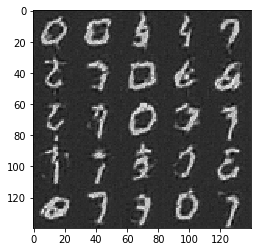

--------------------------------------------------------
Train Step: 860
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 7.61415e-01, Max |Grad|: 1.12328e-01, Min |Grad|: 0.00000e+00, Mean: 2.44312e-05, Std: 1.07374e-03
G_Grad - Norm: 1.44199e-01,  Max |Grad|: 2.23975e-02, Min |Grad|: 0.00000e+00, Mean: 1.05301e-07, Std: 1.50875e-04
Epoch 1/2... Discriminator Loss: 1.3209... Generator Loss: 0.6059
--------------------------------------------------------
Train Step: 880
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 7.36340e-01, Max |Grad|: 1.23936e-01, Min |Grad|: 6.59384e-12, Mean: 1.32377e-05, Std: 1.03859e-03
G_Grad - Norm: 1.59612e-01,  Max |Grad|: 5.74144e-02, Min |Grad|: 0.00000e+00, Mean: 2.87755e-06, Std: 1.66976e-04
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.6052
Image: 22


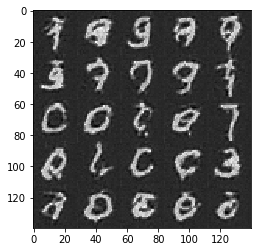

--------------------------------------------------------
Train Step: 900
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 9.54642e-01, Max |Grad|: 1.72539e-01, Min |Grad|: 1.00044e-11, Mean: -1.35083e-05, Std: 1.34642e-03
G_Grad - Norm: 1.38779e-01,  Max |Grad|: 1.51677e-02, Min |Grad|: 0.00000e+00, Mean: -3.30397e-07, Std: 1.45203e-04
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 0.6020
--------------------------------------------------------
Train Step: 920
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 6.84010e-01, Max |Grad|: 9.73604e-02, Min |Grad|: 0.00000e+00, Mean: -5.14390e-06, Std: 9.64670e-04
G_Grad - Norm: 1.46144e-01,  Max |Grad|: 2.94317e-02, Min |Grad|: 0.00000e+00, Mean: -3.75099e-07, Std: 1.52909e-04
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.6098
Image: 23


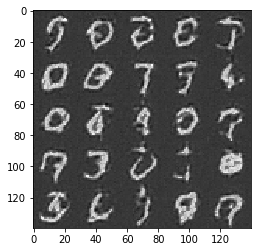

--------------------------------------------------------
Train Step: 940
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 7.86926e-01, Max |Grad|: 7.88547e-02, Min |Grad|: 0.00000e+00, Mean: 9.28721e-06, Std: 1.10994e-03
G_Grad - Norm: 1.39810e-01,  Max |Grad|: 2.29526e-02, Min |Grad|: 0.00000e+00, Mean: 3.42604e-07, Std: 1.46283e-04
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.6072
--------------------------------------------------------
Train Step: 960
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 7.90523e-01, Max |Grad|: 1.20247e-01, Min |Grad|: 0.00000e+00, Mean: -1.97508e-06, Std: 1.11506e-03
G_Grad - Norm: 1.41019e-01,  Max |Grad|: 2.19001e-02, Min |Grad|: 0.00000e+00, Mean: 3.02866e-07, Std: 1.47547e-04
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.5999
Image: 24


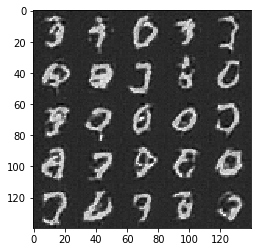

--------------------------------------------------------
Train Step: 980
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 8.21389e-01, Max |Grad|: 1.23509e-01, Min |Grad|: 0.00000e+00, Mean: 6.67766e-06, Std: 1.15858e-03
G_Grad - Norm: 1.39983e-01,  Max |Grad|: 1.70315e-02, Min |Grad|: 0.00000e+00, Mean: -8.64491e-08, Std: 1.46464e-04
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.6108
--------------------------------------------------------
Train Step: 1000
Batch Size: 64, Learning Rate: 0.0001
D_Grad - Norm: 9.08797e-01, Max |Grad|: 1.18310e-01, Min |Grad|: 5.45697e-12, Mean: -4.94284e-06, Std: 1.28182e-03
G_Grad - Norm: 1.55165e-01,  Max |Grad|: 2.67577e-02, Min |Grad|: 0.00000e+00, Mean: 7.97560e-07, Std: 1.62346e-04
Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.6037
Image: 25


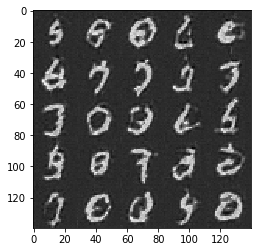

--------------------------------------------------------
Train Step: 1020
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.46342e-01, Max |Grad|: 8.37683e-02, Min |Grad|: 3.97904e-12, Mean: 1.29367e-06, Std: 9.11563e-04
G_Grad - Norm: 1.64575e-01,  Max |Grad|: 2.10727e-02, Min |Grad|: 0.00000e+00, Mean: -1.90729e-06, Std: 1.72183e-04
Epoch 2/2... Discriminator Loss: 1.3160... Generator Loss: 0.6109
--------------------------------------------------------
Train Step: 1040
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.29424e-01, Max |Grad|: 7.28222e-02, Min |Grad|: 0.00000e+00, Mean: -2.42703e-06, Std: 8.87709e-04
G_Grad - Norm: 1.56163e-01,  Max |Grad|: 2.27203e-02, Min |Grad|: 0.00000e+00, Mean: -4.85826e-07, Std: 1.63393e-04
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 0.6077
Image: 26


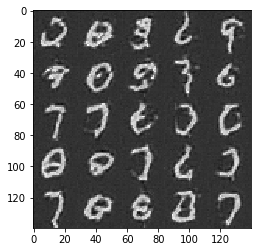

--------------------------------------------------------
Train Step: 1060
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.56317e-01, Max |Grad|: 8.55875e-02, Min |Grad|: 9.09495e-13, Mean: 1.18066e-05, Std: 9.25555e-04
G_Grad - Norm: 1.49441e-01,  Max |Grad|: 1.78711e-02, Min |Grad|: 0.00000e+00, Mean: -1.43497e-06, Std: 1.56353e-04
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 0.6122
--------------------------------------------------------
Train Step: 1080
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 5.39342e-01, Max |Grad|: 6.17383e-02, Min |Grad|: 0.00000e+00, Mean: -2.73288e-06, Std: 7.60662e-04
G_Grad - Norm: 1.63302e-01,  Max |Grad|: 2.48268e-02, Min |Grad|: 0.00000e+00, Mean: -9.40031e-07, Std: 1.70860e-04
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 0.6012
Image: 27


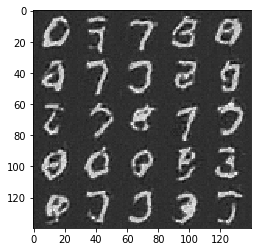

--------------------------------------------------------
Train Step: 1100
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 7.49233e-01, Max |Grad|: 1.40024e-01, Min |Grad|: 2.72848e-12, Mean: -1.10658e-05, Std: 1.05677e-03
G_Grad - Norm: 1.52409e-01,  Max |Grad|: 1.74089e-02, Min |Grad|: 0.00000e+00, Mean: 4.77920e-07, Std: 1.59463e-04
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.6048
--------------------------------------------------------
Train Step: 1120
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 7.30818e-01, Max |Grad|: 8.04251e-02, Min |Grad|: 0.00000e+00, Mean: 3.26343e-06, Std: 1.03086e-03
G_Grad - Norm: 1.56871e-01,  Max |Grad|: 1.97670e-02, Min |Grad|: 1.81899e-12, Mean: -2.45045e-06, Std: 1.64115e-04
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.6074
Image: 28


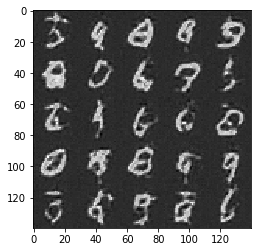

--------------------------------------------------------
Train Step: 1140
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.46873e-01, Max |Grad|: 9.28808e-02, Min |Grad|: 0.00000e+00, Mean: 1.07583e-05, Std: 9.12251e-04
G_Grad - Norm: 1.58226e-01,  Max |Grad|: 2.41597e-02, Min |Grad|: 0.00000e+00, Mean: -1.51565e-06, Std: 1.65544e-04
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.6045
--------------------------------------------------------
Train Step: 1160
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.89620e-01, Max |Grad|: 8.19764e-02, Min |Grad|: 0.00000e+00, Mean: 1.08908e-05, Std: 9.72536e-04
G_Grad - Norm: 1.59175e-01,  Max |Grad|: 2.42428e-02, Min |Grad|: 0.00000e+00, Mean: -1.94458e-06, Std: 1.66532e-04
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 0.6049
Image: 29


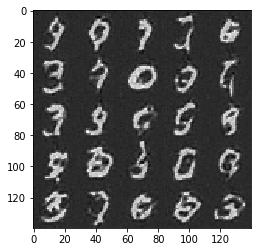

--------------------------------------------------------
Train Step: 1180
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 5.19560e-01, Max |Grad|: 6.59823e-02, Min |Grad|: 1.36424e-12, Mean: -8.88875e-06, Std: 7.32728e-04
G_Grad - Norm: 1.41979e-01,  Max |Grad|: 2.22969e-02, Min |Grad|: 0.00000e+00, Mean: 3.48271e-07, Std: 1.48551e-04
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.6081
--------------------------------------------------------
Train Step: 1200
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.06916e-01, Max |Grad|: 9.09546e-02, Min |Grad|: 0.00000e+00, Mean: -9.29905e-06, Std: 8.55916e-04
G_Grad - Norm: 1.60862e-01,  Max |Grad|: 2.07950e-02, Min |Grad|: 9.09495e-13, Mean: -2.45512e-06, Std: 1.68290e-04
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.6021
Image: 30


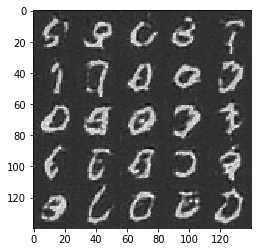

--------------------------------------------------------
Train Step: 1220
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.39984e-01, Max |Grad|: 8.67532e-02, Min |Grad|: 0.00000e+00, Mean: 8.23007e-08, Std: 9.02591e-04
G_Grad - Norm: 1.48190e-01,  Max |Grad|: 1.52875e-02, Min |Grad|: 0.00000e+00, Mean: -1.49335e-06, Std: 1.55043e-04
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.5990
--------------------------------------------------------
Train Step: 1240
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.89311e-01, Max |Grad|: 6.96983e-02, Min |Grad|: 5.64171e-12, Mean: -1.86035e-06, Std: 9.72158e-04
G_Grad - Norm: 1.50374e-01,  Max |Grad|: 1.08913e-02, Min |Grad|: 0.00000e+00, Mean: 1.20825e-06, Std: 1.57331e-04
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.6090
Image: 31


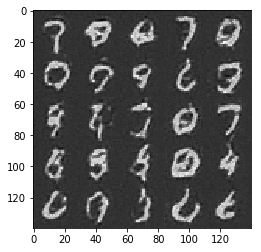

--------------------------------------------------------
Train Step: 1260
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 7.19099e-01, Max |Grad|: 6.85333e-02, Min |Grad|: 5.45697e-12, Mean: -8.32006e-06, Std: 1.01430e-03
G_Grad - Norm: 1.58016e-01,  Max |Grad|: 2.11231e-02, Min |Grad|: 1.81899e-12, Mean: 1.79298e-06, Std: 1.65323e-04
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.5946
--------------------------------------------------------
Train Step: 1280
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.25399e-01, Max |Grad|: 6.84941e-02, Min |Grad|: 1.00897e-11, Mean: -2.86693e-06, Std: 8.82023e-04
G_Grad - Norm: 1.60926e-01,  Max |Grad|: 2.43601e-02, Min |Grad|: 0.00000e+00, Mean: 7.71216e-07, Std: 1.68375e-04
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.6068
Image: 32


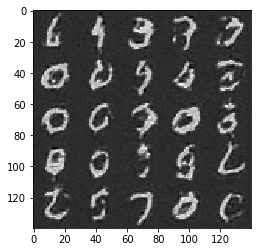

--------------------------------------------------------
Train Step: 1300
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.22316e-01, Max |Grad|: 7.99441e-02, Min |Grad|: 0.00000e+00, Mean: 1.14351e-05, Std: 8.77613e-04
G_Grad - Norm: 1.58455e-01,  Max |Grad|: 3.80052e-02, Min |Grad|: 0.00000e+00, Mean: -1.68275e-07, Std: 1.65790e-04
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.6044
--------------------------------------------------------
Train Step: 1320
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.50210e-01, Max |Grad|: 7.41521e-02, Min |Grad|: 0.00000e+00, Mean: -4.06989e-07, Std: 9.17018e-04
G_Grad - Norm: 1.56780e-01,  Max |Grad|: 3.39124e-02, Min |Grad|: 0.00000e+00, Mean: -9.55990e-07, Std: 1.64036e-04
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.6067
Image: 33


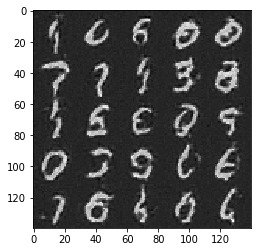

--------------------------------------------------------
Train Step: 1340
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 5.87368e-01, Max |Grad|: 7.73811e-02, Min |Grad|: 3.63798e-12, Mean: -5.39027e-06, Std: 8.28368e-04
G_Grad - Norm: 1.59045e-01,  Max |Grad|: 2.00706e-02, Min |Grad|: 0.00000e+00, Mean: -4.40792e-07, Std: 1.66407e-04
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.6059
--------------------------------------------------------
Train Step: 1360
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 7.28776e-01, Max |Grad|: 8.78493e-02, Min |Grad|: 3.18323e-12, Mean: -1.14336e-05, Std: 1.02792e-03
G_Grad - Norm: 1.49460e-01,  Max |Grad|: 1.84047e-02, Min |Grad|: 1.81899e-12, Mean: -7.92657e-07, Std: 1.56377e-04
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.6010
Image: 34


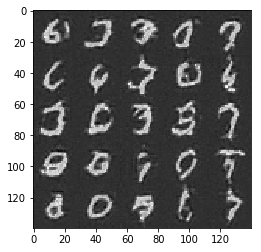

--------------------------------------------------------
Train Step: 1380
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 9.89843e-01, Max |Grad|: 1.12702e-01, Min |Grad|: 0.00000e+00, Mean: -2.98896e-06, Std: 1.39609e-03
G_Grad - Norm: 1.43583e-01,  Max |Grad|: 1.41386e-02, Min |Grad|: 0.00000e+00, Mean: 3.80863e-07, Std: 1.50230e-04
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.5953
--------------------------------------------------------
Train Step: 1400
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 8.38827e-01, Max |Grad|: 9.54554e-02, Min |Grad|: 0.00000e+00, Mean: 9.79057e-06, Std: 1.18312e-03
G_Grad - Norm: 1.43679e-01,  Max |Grad|: 2.06937e-02, Min |Grad|: 0.00000e+00, Mean: 1.85732e-06, Std: 1.50319e-04
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 0.6045
Image: 35


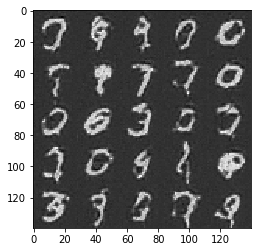

--------------------------------------------------------
Train Step: 1420
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 8.45525e-01, Max |Grad|: 1.17730e-01, Min |Grad|: 0.00000e+00, Mean: 1.76742e-05, Std: 1.19248e-03
G_Grad - Norm: 1.39389e-01,  Max |Grad|: 1.25913e-02, Min |Grad|: 0.00000e+00, Mean: 1.19786e-07, Std: 1.45841e-04
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.6077
--------------------------------------------------------
Train Step: 1440
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 9.64203e-01, Max |Grad|: 8.65966e-02, Min |Grad|: 0.00000e+00, Mean: 4.26556e-07, Std: 1.35993e-03
G_Grad - Norm: 1.51421e-01,  Max |Grad|: 2.26234e-02, Min |Grad|: 0.00000e+00, Mean: 2.54428e-06, Std: 1.58410e-04
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.6041
Image: 36


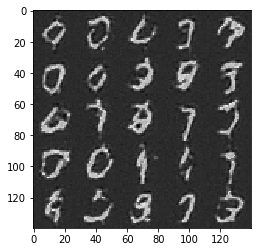

--------------------------------------------------------
Train Step: 1460
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.62812e-01, Max |Grad|: 1.22632e-01, Min |Grad|: 2.27374e-12, Mean: -1.43662e-05, Std: 9.34677e-04
G_Grad - Norm: 1.50063e-01,  Max |Grad|: 1.46458e-02, Min |Grad|: 0.00000e+00, Mean: -1.44629e-06, Std: 1.57004e-04
Epoch 2/2... Discriminator Loss: 1.2904... Generator Loss: 0.6045
--------------------------------------------------------
Train Step: 1480
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.06888e-01, Max |Grad|: 7.04015e-02, Min |Grad|: 0.00000e+00, Mean: -1.84470e-06, Std: 8.55928e-04
G_Grad - Norm: 1.78100e-01,  Max |Grad|: 3.68351e-02, Min |Grad|: 0.00000e+00, Mean: 3.04519e-06, Std: 1.86321e-04
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.6033
Image: 37


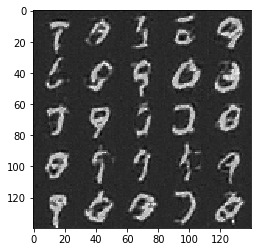

--------------------------------------------------------
Train Step: 1500
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 1.04768e+00, Max |Grad|: 1.65569e-01, Min |Grad|: 3.97904e-12, Mean: -1.69900e-05, Std: 1.47800e-03
G_Grad - Norm: 1.59275e-01,  Max |Grad|: 1.75327e-02, Min |Grad|: 0.00000e+00, Mean: -1.59790e-07, Std: 1.66648e-04
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.6079
--------------------------------------------------------
Train Step: 1520
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.95303e-01, Max |Grad|: 7.94509e-02, Min |Grad|: 9.66338e-13, Mean: 1.60580e-05, Std: 9.80471e-04
G_Grad - Norm: 1.71077e-01,  Max |Grad|: 2.31450e-02, Min |Grad|: 2.72848e-12, Mean: -9.71628e-07, Std: 1.78995e-04
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.5963
Image: 38


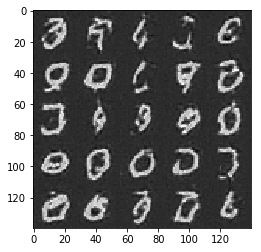

--------------------------------------------------------
Train Step: 1540
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.00682e-01, Max |Grad|: 8.17786e-02, Min |Grad|: 0.00000e+00, Mean: 5.83926e-06, Std: 8.47156e-04
G_Grad - Norm: 1.51431e-01,  Max |Grad|: 2.43192e-02, Min |Grad|: 0.00000e+00, Mean: -1.89445e-07, Std: 1.58441e-04
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.6012
--------------------------------------------------------
Train Step: 1560
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 5.90639e-01, Max |Grad|: 8.66319e-02, Min |Grad|: 5.45697e-12, Mean: 1.37936e-06, Std: 8.33007e-04
G_Grad - Norm: 1.65548e-01,  Max |Grad|: 2.66702e-02, Min |Grad|: 0.00000e+00, Mean: -3.59829e-08, Std: 1.73213e-04
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.6050
Image: 39


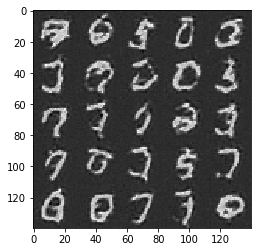

--------------------------------------------------------
Train Step: 1580
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.82630e-01, Max |Grad|: 1.00941e-01, Min |Grad|: 0.00000e+00, Mean: 3.72176e-06, Std: 9.62724e-04
G_Grad - Norm: 1.55994e-01,  Max |Grad|: 2.71183e-02, Min |Grad|: 0.00000e+00, Mean: 1.53393e-06, Std: 1.63209e-04
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.6053
--------------------------------------------------------
Train Step: 1600
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.90302e-01, Max |Grad|: 6.22029e-02, Min |Grad|: 5.45697e-12, Mean: -1.07002e-05, Std: 9.73490e-04
G_Grad - Norm: 1.66596e-01,  Max |Grad|: 3.01662e-02, Min |Grad|: 3.63798e-12, Mean: 5.78218e-07, Std: 1.74308e-04
Epoch 2/2... Discriminator Loss: 1.3039... Generator Loss: 0.5991
Image: 40


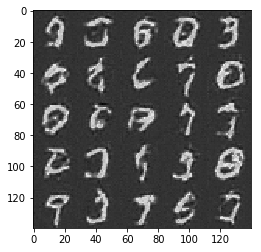

--------------------------------------------------------
Train Step: 1620
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 5.98756e-01, Max |Grad|: 7.91787e-02, Min |Grad|: 7.04858e-12, Mean: -6.18760e-08, Std: 8.44458e-04
G_Grad - Norm: 1.50992e-01,  Max |Grad|: 1.63163e-02, Min |Grad|: 0.00000e+00, Mean: 9.31250e-07, Std: 1.57979e-04
Epoch 2/2... Discriminator Loss: 1.3013... Generator Loss: 0.5992
--------------------------------------------------------
Train Step: 1640
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.10392e-01, Max |Grad|: 8.14891e-02, Min |Grad|: 1.81899e-12, Mean: 1.68911e-06, Std: 8.60863e-04
G_Grad - Norm: 1.61134e-01,  Max |Grad|: 2.25632e-02, Min |Grad|: 1.59162e-12, Mean: -6.46063e-07, Std: 1.68593e-04
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.6119
Image: 41


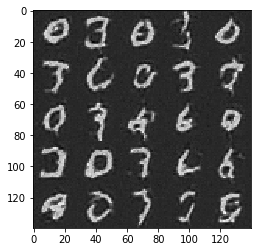

--------------------------------------------------------
Train Step: 1660
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 8.94493e-01, Max |Grad|: 8.78891e-02, Min |Grad|: 5.45697e-12, Mean: -5.62095e-08, Std: 1.26165e-03
G_Grad - Norm: 1.48431e-01,  Max |Grad|: 4.11401e-02, Min |Grad|: 0.00000e+00, Mean: -1.54217e-06, Std: 1.55295e-04
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 0.6132
--------------------------------------------------------
Train Step: 1680
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 9.36246e-01, Max |Grad|: 9.15473e-02, Min |Grad|: 3.63798e-12, Mean: -3.34600e-06, Std: 1.32052e-03
G_Grad - Norm: 1.58435e-01,  Max |Grad|: 2.21109e-02, Min |Grad|: 0.00000e+00, Mean: -1.53320e-06, Std: 1.65763e-04
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.6139
Image: 42


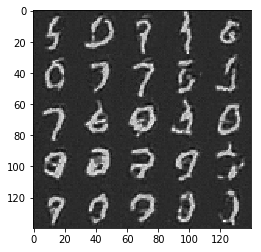

--------------------------------------------------------
Train Step: 1700
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.92505e-01, Max |Grad|: 8.21124e-02, Min |Grad|: 3.63798e-12, Mean: 1.69630e-05, Std: 9.76518e-04
G_Grad - Norm: 1.64747e-01,  Max |Grad|: 2.52588e-02, Min |Grad|: 0.00000e+00, Mean: -1.02935e-06, Std: 1.72370e-04
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.6043
--------------------------------------------------------
Train Step: 1720
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 5.54665e-01, Max |Grad|: 5.84498e-02, Min |Grad|: 0.00000e+00, Mean: -7.85060e-06, Std: 7.82244e-04
G_Grad - Norm: 1.52964e-01,  Max |Grad|: 2.63032e-02, Min |Grad|: 0.00000e+00, Mean: 9.23841e-07, Std: 1.60043e-04
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.6052
Image: 43


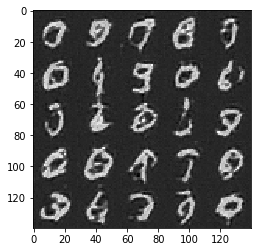

--------------------------------------------------------
Train Step: 1740
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 9.20434e-01, Max |Grad|: 1.29423e-01, Min |Grad|: 1.81899e-12, Mean: 2.36795e-05, Std: 1.29801e-03
G_Grad - Norm: 1.66054e-01,  Max |Grad|: 2.24706e-02, Min |Grad|: 0.00000e+00, Mean: -4.16956e-07, Std: 1.73741e-04
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.6069
--------------------------------------------------------
Train Step: 1760
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.82366e-01, Max |Grad|: 9.34536e-02, Min |Grad|: 8.46967e-12, Mean: 2.46627e-06, Std: 9.62363e-04
G_Grad - Norm: 1.60672e-01,  Max |Grad|: 2.30788e-02, Min |Grad|: 0.00000e+00, Mean: -1.94365e-07, Std: 1.68111e-04
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.6031
Image: 44


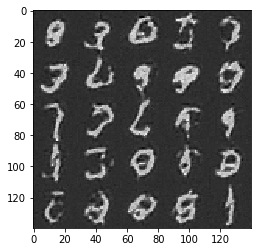

--------------------------------------------------------
Train Step: 1780
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 8.09002e-01, Max |Grad|: 8.21110e-02, Min |Grad|: 0.00000e+00, Mean: -7.32917e-06, Std: 1.14105e-03
G_Grad - Norm: 1.70782e-01,  Max |Grad|: 2.60220e-02, Min |Grad|: 0.00000e+00, Mean: -1.43512e-06, Std: 1.78682e-04
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.6082
--------------------------------------------------------
Train Step: 1800
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 5.98703e-01, Max |Grad|: 7.05506e-02, Min |Grad|: 0.00000e+00, Mean: -1.20576e-05, Std: 8.44288e-04
G_Grad - Norm: 1.60227e-01,  Max |Grad|: 3.58187e-02, Min |Grad|: 3.41061e-12, Mean: 1.11085e-06, Std: 1.67641e-04
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.5960
Image: 45


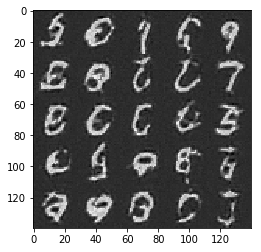

--------------------------------------------------------
Train Step: 1820
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 6.64538e-01, Max |Grad|: 7.73384e-02, Min |Grad|: 5.45697e-12, Mean: -2.05048e-07, Std: 9.37220e-04
G_Grad - Norm: 1.47238e-01,  Max |Grad|: 9.13908e-03, Min |Grad|: 0.00000e+00, Mean: 1.44337e-07, Std: 1.54053e-04
Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.6005
--------------------------------------------------------
Train Step: 1840
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 1.12392e+00, Max |Grad|: 1.70090e-01, Min |Grad|: 0.00000e+00, Mean: -8.90938e-06, Std: 1.58556e-03
G_Grad - Norm: 1.68752e-01,  Max |Grad|: 4.03036e-02, Min |Grad|: 3.63798e-12, Mean: 3.67930e-07, Std: 1.76564e-04
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.5987
Image: 46


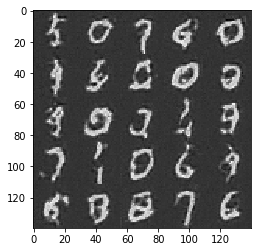

--------------------------------------------------------
Train Step: 1860
Batch Size: 64, Learning Rate: 1e-05
D_Grad - Norm: 8.58800e-01, Max |Grad|: 9.82502e-02, Min |Grad|: 7.27596e-12, Mean: -1.18443e-06, Std: 1.21131e-03
G_Grad - Norm: 1.87991e-01,  Max |Grad|: 5.78583e-02, Min |Grad|: 1.81899e-12, Mean: 3.61626e-07, Std: 1.96695e-04
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.6109


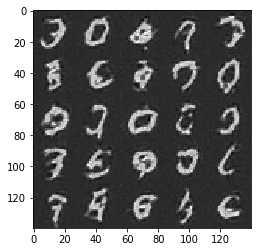

In [78]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1
alpha = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, 
          beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Length of gradients: 12
Length of gradients: 14
--------------------------------------------------------
Train Step: 20
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 2.45971e-01, Max |Grad|: 1.98947e-02, Min |Grad|: 0.00000e+00, Mean: 9.90274e-07, Std: 3.45791e-04
G_Grad - Norm: 1.96304e-02,  Max |Grad|: 1.53153e-03, Min |Grad|: 0.00000e+00, Mean: -3.83832e-07, Std: 1.58078e-05
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 0.6185
--------------------------------------------------------
Train Step: 40
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 2.23872e-01, Max |Grad|: 2.94840e-02, Min |Grad|: 4.54747e-12, Mean: 1.68311e-06, Std: 3.14720e-04
G_Grad - Norm: 5.72008e-02,  Max |Grad|: 1.08818e-02, Min |Grad|: 0.00000e+00, Mean: 7.43745e-08, Std: 4.60759e-05
Epoch 1/2... Discriminator Loss: 1.3640... Generator Loss: 0.5162
Image: 1


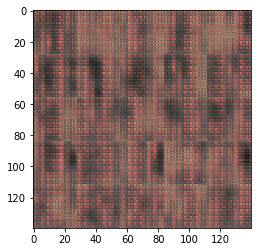

--------------------------------------------------------
Train Step: 60
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 4.52007e-01, Max |Grad|: 6.34865e-02, Min |Grad|: 9.09495e-13, Mean: -2.28564e-05, Std: 6.35047e-04
G_Grad - Norm: 1.50774e-01,  Max |Grad|: 3.50188e-02, Min |Grad|: 2.27374e-13, Mean: 2.23612e-07, Std: 1.21450e-04
Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.5463
--------------------------------------------------------
Train Step: 80
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 3.31908e-01, Max |Grad|: 2.74243e-02, Min |Grad|: 3.55271e-14, Mean: -1.14809e-05, Std: 4.66469e-04
G_Grad - Norm: 1.07451e-01,  Max |Grad|: 3.29121e-02, Min |Grad|: 0.00000e+00, Mean: 9.71051e-08, Std: 8.65529e-05
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 0.5949
Image: 2


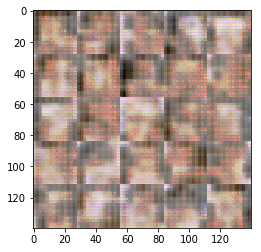

--------------------------------------------------------
Train Step: 100
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 5.81433e-01, Max |Grad|: 1.17446e-01, Min |Grad|: 4.04121e-13, Mean: -1.37731e-06, Std: 8.17458e-04
G_Grad - Norm: 1.63255e-01,  Max |Grad|: 5.33925e-02, Min |Grad|: 1.13687e-13, Mean: -1.14004e-06, Std: 1.31499e-04
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.5753
--------------------------------------------------------
Train Step: 120
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 6.75625e-01, Max |Grad|: 1.02525e-01, Min |Grad|: 1.53833e-12, Mean: -6.94444e-06, Std: 9.49852e-04
G_Grad - Norm: 2.14140e-01,  Max |Grad|: 7.08800e-02, Min |Grad|: 0.00000e+00, Mean: -1.80896e-07, Std: 1.72493e-04
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.5332
Image: 3


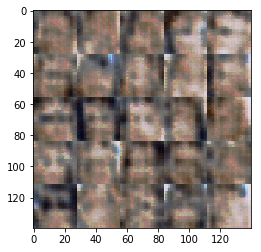

--------------------------------------------------------
Train Step: 140
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 4.09808e-01, Max |Grad|: 3.88298e-02, Min |Grad|: 0.00000e+00, Mean: -1.57531e-05, Std: 5.75957e-04
G_Grad - Norm: 4.75178e-02,  Max |Grad|: 8.41075e-03, Min |Grad|: 0.00000e+00, Mean: 5.52340e-07, Std: 3.82723e-05
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.6300
--------------------------------------------------------
Train Step: 160
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 2.54772e-01, Max |Grad|: 3.91940e-02, Min |Grad|: 7.70939e-13, Mean: -1.10345e-06, Std: 3.58166e-04
G_Grad - Norm: 1.62444e-01,  Max |Grad|: 7.07036e-02, Min |Grad|: 0.00000e+00, Mean: 4.00508e-07, Std: 1.30850e-04
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.5856
Image: 4


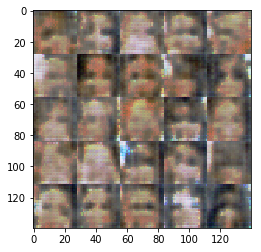

--------------------------------------------------------
Train Step: 180
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 5.31983e-01, Max |Grad|: 3.69234e-02, Min |Grad|: 6.25278e-12, Mean: -2.46811e-05, Std: 7.47654e-04
G_Grad - Norm: 2.61030e-01,  Max |Grad|: 9.56655e-02, Min |Grad|: 6.82121e-13, Mean: 3.86976e-07, Std: 2.10262e-04
Epoch 1/2... Discriminator Loss: 1.3681... Generator Loss: 0.5873
--------------------------------------------------------
Train Step: 200
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 8.74861e-01, Max |Grad|: 1.20759e-01, Min |Grad|: 0.00000e+00, Mean: 3.08693e-05, Std: 1.22980e-03
G_Grad - Norm: 1.69036e-01,  Max |Grad|: 6.24532e-02, Min |Grad|: 0.00000e+00, Mean: -7.14520e-07, Std: 1.36159e-04
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.5757
Image: 5


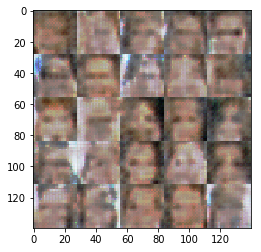

--------------------------------------------------------
Train Step: 220
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 3.47534e-01, Max |Grad|: 1.10268e-01, Min |Grad|: 8.34444e-13, Mean: -3.68187e-06, Std: 4.88576e-04
G_Grad - Norm: 2.61293e-01,  Max |Grad|: 1.09810e-01, Min |Grad|: 2.27374e-13, Mean: 2.83928e-07, Std: 2.10475e-04
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.6053
--------------------------------------------------------
Train Step: 240
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 5.87438e-01, Max |Grad|: 5.23171e-02, Min |Grad|: 0.00000e+00, Mean: -5.93786e-05, Std: 8.23827e-04
G_Grad - Norm: 7.45426e-02,  Max |Grad|: 1.56140e-02, Min |Grad|: 4.54747e-13, Mean: -2.25747e-07, Std: 6.00445e-05
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 0.5725
Image: 6


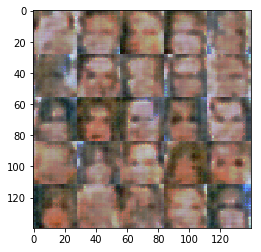

--------------------------------------------------------
Train Step: 260
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 6.16287e-01, Max |Grad|: 1.20321e-01, Min |Grad|: 1.52056e-12, Mean: -2.56086e-05, Std: 8.66122e-04
G_Grad - Norm: 2.46877e-01,  Max |Grad|: 1.05856e-01, Min |Grad|: 0.00000e+00, Mean: 1.56332e-07, Std: 1.98862e-04
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.5864
--------------------------------------------------------
Train Step: 280
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 3.08876e-01, Max |Grad|: 4.11731e-02, Min |Grad|: 2.40169e-13, Mean: 3.92351e-06, Std: 4.34226e-04
G_Grad - Norm: 1.33210e-01,  Max |Grad|: 4.64869e-02, Min |Grad|: 1.81899e-12, Mean: 1.67309e-06, Std: 1.07289e-04
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 0.6070
Image: 7


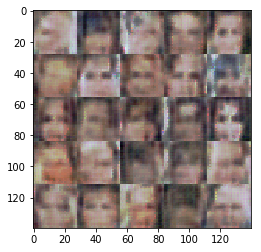

--------------------------------------------------------
Train Step: 300
Batch Size: 128, Learning Rate: 0.001
D_Grad - Norm: 6.35232e-01, Max |Grad|: 1.63910e-01, Min |Grad|: 0.00000e+00, Mean: 1.06943e-05, Std: 8.93098e-04
G_Grad - Norm: 4.97590e-01,  Max |Grad|: 2.33546e-01, Min |Grad|: 0.00000e+00, Mean: -4.67533e-07, Std: 4.00815e-04
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.5926
--------------------------------------------------------
Train Step: 320
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.49762e-01, Max |Grad|: 3.19594e-02, Min |Grad|: 2.85105e-12, Mean: -7.46941e-06, Std: 3.51045e-04
G_Grad - Norm: 6.62807e-02,  Max |Grad|: 1.30959e-02, Min |Grad|: 9.09495e-13, Mean: 7.48983e-08, Std: 5.33900e-05
Epoch 1/2... Discriminator Loss: 1.3429... Generator Loss: 0.5919
Image: 8


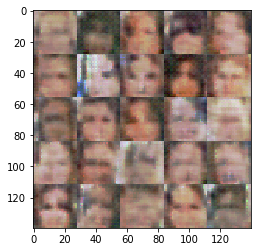

--------------------------------------------------------
Train Step: 340
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.36959e-01, Max |Grad|: 3.07377e-02, Min |Grad|: 4.92051e-13, Mean: -2.98999e-06, Std: 3.33114e-04
G_Grad - Norm: 7.31720e-02,  Max |Grad|: 1.78526e-02, Min |Grad|: 0.00000e+00, Mean: -1.19679e-07, Std: 5.89410e-05
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.5932
--------------------------------------------------------
Train Step: 360
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 1.95454e-01, Max |Grad|: 3.05612e-02, Min |Grad|: 0.00000e+00, Mean: 2.78366e-06, Std: 2.74764e-04
G_Grad - Norm: 6.71120e-02,  Max |Grad|: 9.39818e-03, Min |Grad|: 0.00000e+00, Mean: 5.57852e-07, Std: 5.40564e-05
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.5893
Image: 9


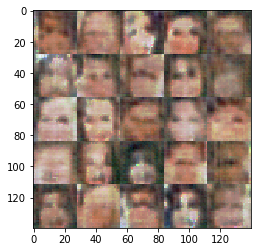

--------------------------------------------------------
Train Step: 380
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.41946e-01, Max |Grad|: 2.12926e-02, Min |Grad|: 1.59162e-12, Mean: -1.44118e-05, Std: 3.39830e-04
G_Grad - Norm: 6.98282e-02,  Max |Grad|: 1.20816e-02, Min |Grad|: 9.09495e-13, Mean: -2.01155e-07, Std: 5.62474e-05
Epoch 1/2... Discriminator Loss: 1.3552... Generator Loss: 0.5873
--------------------------------------------------------
Train Step: 400
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.60296e-01, Max |Grad|: 3.02679e-02, Min |Grad|: 1.50635e-12, Mean: 7.45978e-06, Std: 3.65872e-04
G_Grad - Norm: 7.29568e-02,  Max |Grad|: 1.97918e-02, Min |Grad|: 0.00000e+00, Mean: 7.25758e-07, Std: 5.87632e-05
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.5944
Image: 10


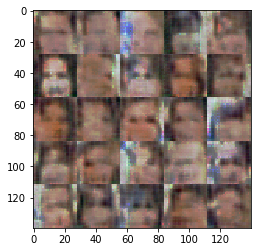

--------------------------------------------------------
Train Step: 420
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.41916e-01, Max |Grad|: 2.95397e-02, Min |Grad|: 1.81899e-12, Mean: -6.24631e-06, Std: 3.40035e-04
G_Grad - Norm: 8.45303e-02,  Max |Grad|: 1.45285e-02, Min |Grad|: 1.36424e-12, Mean: 1.76476e-07, Std: 6.80900e-05
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.5891
--------------------------------------------------------
Train Step: 440
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.05903e-01, Max |Grad|: 4.20760e-02, Min |Grad|: 0.00000e+00, Mean: -7.34723e-06, Std: 4.29994e-04
G_Grad - Norm: 7.18995e-02,  Max |Grad|: 2.18005e-02, Min |Grad|: 0.00000e+00, Mean: -3.86256e-07, Std: 5.79145e-05
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.5831
Image: 11


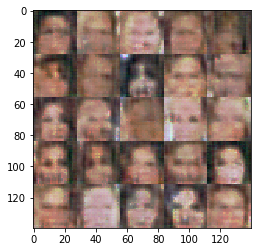

--------------------------------------------------------
Train Step: 460
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.54734e-01, Max |Grad|: 4.35558e-02, Min |Grad|: 7.38964e-13, Mean: -1.51398e-05, Std: 3.57806e-04
G_Grad - Norm: 6.65524e-02,  Max |Grad|: 2.40618e-02, Min |Grad|: 0.00000e+00, Mean: -1.13172e-07, Std: 5.36087e-05
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.5874
--------------------------------------------------------
Train Step: 480
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.26349e-01, Max |Grad|: 2.55346e-02, Min |Grad|: 3.63798e-12, Mean: -6.49326e-06, Std: 3.18144e-04
G_Grad - Norm: 6.24288e-02,  Max |Grad|: 9.45787e-03, Min |Grad|: 0.00000e+00, Mean: -2.58743e-07, Std: 5.02865e-05
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.5858
Image: 12


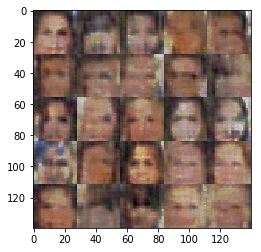

--------------------------------------------------------
Train Step: 500
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 1.93475e-01, Max |Grad|: 2.88268e-02, Min |Grad|: 1.25056e-12, Mean: -4.16967e-06, Std: 2.71965e-04
G_Grad - Norm: 6.40193e-02,  Max |Grad|: 1.17214e-02, Min |Grad|: 1.81899e-12, Mean: 2.59530e-07, Std: 5.15676e-05
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.5954
--------------------------------------------------------
Train Step: 520
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.96374e-01, Max |Grad|: 4.34892e-02, Min |Grad|: 0.00000e+00, Mean: -8.59362e-06, Std: 4.16575e-04
G_Grad - Norm: 8.32076e-02,  Max |Grad|: 1.53870e-02, Min |Grad|: 0.00000e+00, Mean: 1.63377e-07, Std: 6.70247e-05
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.5898
Image: 13


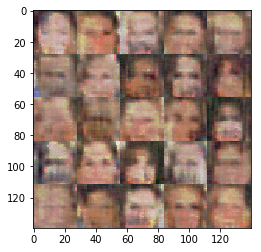

--------------------------------------------------------
Train Step: 540
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.62862e-01, Max |Grad|: 2.48606e-02, Min |Grad|: 1.81899e-12, Mean: 6.37142e-06, Std: 3.69493e-04
G_Grad - Norm: 6.73415e-02,  Max |Grad|: 1.57354e-02, Min |Grad|: 6.82121e-13, Mean: 5.89437e-07, Std: 5.42413e-05
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.5879
--------------------------------------------------------
Train Step: 560
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.48314e-01, Max |Grad|: 2.75473e-02, Min |Grad|: 0.00000e+00, Mean: -4.83973e-07, Std: 3.49090e-04
G_Grad - Norm: 5.73824e-02,  Max |Grad|: 1.18642e-02, Min |Grad|: 0.00000e+00, Mean: 3.42098e-07, Std: 4.62211e-05
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.5935
Image: 14


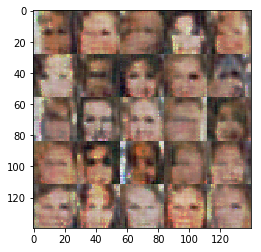

--------------------------------------------------------
Train Step: 580
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.93041e-01, Max |Grad|: 3.04181e-02, Min |Grad|: 1.06866e-11, Mean: -7.15064e-06, Std: 4.11913e-04
G_Grad - Norm: 6.93839e-02,  Max |Grad|: 1.14029e-02, Min |Grad|: 0.00000e+00, Mean: 9.16805e-08, Std: 5.58895e-05
Epoch 1/2... Discriminator Loss: 1.3629... Generator Loss: 0.5872
--------------------------------------------------------
Train Step: 600
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.00676e-01, Max |Grad|: 2.85379e-02, Min |Grad|: 3.63798e-12, Mean: 3.50718e-06, Std: 4.22700e-04
G_Grad - Norm: 5.83689e-02,  Max |Grad|: 9.53101e-03, Min |Grad|: 0.00000e+00, Mean: 9.21058e-08, Std: 4.70169e-05
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.5898
Image: 15


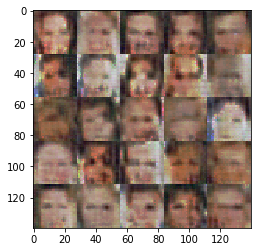

--------------------------------------------------------
Train Step: 620
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.85334e-01, Max |Grad|: 3.07624e-02, Min |Grad|: 0.00000e+00, Mean: -1.02900e-05, Std: 4.01008e-04
G_Grad - Norm: 6.25170e-02,  Max |Grad|: 1.46866e-02, Min |Grad|: 0.00000e+00, Mean: -2.74538e-07, Std: 5.03575e-05
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.5868
--------------------------------------------------------
Train Step: 640
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.53212e-01, Max |Grad|: 2.72324e-02, Min |Grad|: 0.00000e+00, Mean: -1.55067e-06, Std: 3.55983e-04
G_Grad - Norm: 7.71004e-02,  Max |Grad|: 1.72747e-02, Min |Grad|: 2.27374e-13, Mean: -1.14682e-07, Std: 6.21054e-05
Epoch 1/2... Discriminator Loss: 1.3585... Generator Loss: 0.5873
Image: 16


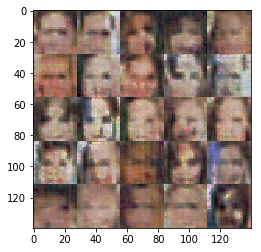

--------------------------------------------------------
Train Step: 660
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.51919e-01, Max |Grad|: 3.99633e-02, Min |Grad|: 1.25056e-11, Mean: 4.55193e-06, Std: 4.94723e-04
G_Grad - Norm: 7.44229e-02,  Max |Grad|: 9.80670e-03, Min |Grad|: 0.00000e+00, Mean: 4.17892e-07, Std: 5.99470e-05
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.5828
--------------------------------------------------------
Train Step: 680
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.23078e-01, Max |Grad|: 2.57602e-02, Min |Grad|: 0.00000e+00, Mean: -2.33250e-06, Std: 4.54195e-04
G_Grad - Norm: 9.89854e-02,  Max |Grad|: 2.69087e-02, Min |Grad|: 4.54747e-13, Mean: 8.92107e-07, Std: 7.97291e-05
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.5955
Image: 17


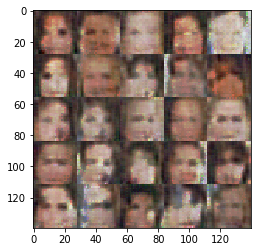

--------------------------------------------------------
Train Step: 700
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.38512e-01, Max |Grad|: 3.44967e-02, Min |Grad|: 9.09495e-13, Mean: 6.13349e-06, Std: 3.35252e-04
G_Grad - Norm: 6.15384e-02,  Max |Grad|: 1.04767e-02, Min |Grad|: 1.36424e-12, Mean: 3.17955e-07, Std: 4.95690e-05
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.5834
--------------------------------------------------------
Train Step: 720
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.41288e-01, Max |Grad|: 3.37417e-02, Min |Grad|: 0.00000e+00, Mean: 8.87600e-06, Std: 4.79714e-04
G_Grad - Norm: 7.70210e-02,  Max |Grad|: 1.64321e-02, Min |Grad|: 0.00000e+00, Mean: 2.59374e-07, Std: 6.20409e-05
Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.5864
Image: 18


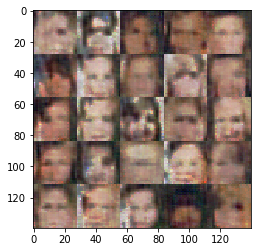

--------------------------------------------------------
Train Step: 740
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 4.16609e-01, Max |Grad|: 7.59380e-02, Min |Grad|: 9.09495e-13, Mean: 5.49069e-06, Std: 5.85692e-04
G_Grad - Norm: 7.01662e-02,  Max |Grad|: 1.00916e-02, Min |Grad|: 1.81899e-12, Mean: 4.81477e-07, Std: 5.65178e-05
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.5891
--------------------------------------------------------
Train Step: 760
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.53744e-01, Max |Grad|: 2.66192e-02, Min |Grad|: 0.00000e+00, Mean: -1.29629e-05, Std: 4.97143e-04
G_Grad - Norm: 7.93503e-02,  Max |Grad|: 1.27934e-02, Min |Grad|: 0.00000e+00, Mean: -3.49059e-07, Std: 6.39167e-05
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.5810
Image: 19


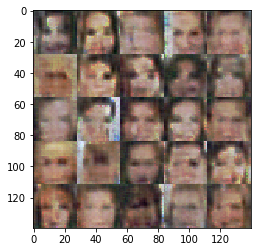

--------------------------------------------------------
Train Step: 780
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.02662e-01, Max |Grad|: 2.79405e-02, Min |Grad|: 7.95808e-13, Mean: -4.55267e-06, Std: 4.25475e-04
G_Grad - Norm: 8.53306e-02,  Max |Grad|: 1.62464e-02, Min |Grad|: 4.54747e-13, Mean: -6.70166e-07, Std: 6.87316e-05
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.5839
--------------------------------------------------------
Train Step: 800
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 2.91064e-01, Max |Grad|: 2.95285e-02, Min |Grad|: 0.00000e+00, Mean: -1.12471e-05, Std: 4.09041e-04
G_Grad - Norm: 9.35605e-02,  Max |Grad|: 2.85208e-02, Min |Grad|: 2.72848e-12, Mean: -4.52146e-07, Std: 7.53629e-05
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.5856
Image: 20


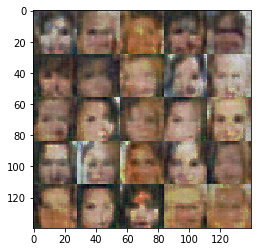

--------------------------------------------------------
Train Step: 820
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.56718e-01, Max |Grad|: 4.76784e-02, Min |Grad|: 0.00000e+00, Mean: -4.32775e-06, Std: 5.01502e-04
G_Grad - Norm: 2.77941e-01,  Max |Grad|: 1.01736e-01, Min |Grad|: 9.09495e-13, Mean: 2.91940e-07, Std: 2.23885e-04
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.5808
--------------------------------------------------------
Train Step: 840
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.99773e-01, Max |Grad|: 5.38856e-02, Min |Grad|: 1.81899e-12, Mean: -4.24423e-06, Std: 5.62022e-04
G_Grad - Norm: 9.71298e-02,  Max |Grad|: 1.86587e-02, Min |Grad|: 3.62377e-12, Mean: 6.64313e-07, Std: 7.82365e-05
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.5708
Image: 21


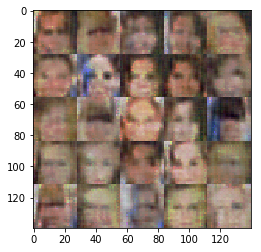

--------------------------------------------------------
Train Step: 860
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 4.60254e-01, Max |Grad|: 5.37606e-02, Min |Grad|: 1.53477e-12, Mean: -4.08984e-06, Std: 6.47063e-04
G_Grad - Norm: 1.55735e-01,  Max |Grad|: 2.95131e-02, Min |Grad|: 0.00000e+00, Mean: -1.81855e-07, Std: 1.25447e-04
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.5870
--------------------------------------------------------
Train Step: 880
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.66545e-01, Max |Grad|: 4.80486e-02, Min |Grad|: 6.99174e-12, Mean: -1.32203e-05, Std: 5.15169e-04
G_Grad - Norm: 1.12453e-01,  Max |Grad|: 3.80038e-02, Min |Grad|: 1.36424e-12, Mean: -7.72617e-08, Std: 9.05820e-05
Epoch 1/2... Discriminator Loss: 1.3654... Generator Loss: 0.5831
Image: 22


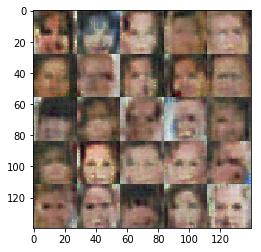

--------------------------------------------------------
Train Step: 900
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.63501e-01, Max |Grad|: 4.98740e-02, Min |Grad|: 7.27596e-12, Mean: -9.21799e-06, Std: 5.10973e-04
G_Grad - Norm: 1.21239e-01,  Max |Grad|: 4.30466e-02, Min |Grad|: 0.00000e+00, Mean: 2.47204e-07, Std: 9.76591e-05
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.5835
--------------------------------------------------------
Train Step: 920
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 4.00638e-01, Max |Grad|: 4.68437e-02, Min |Grad|: 1.58593e-11, Mean: -1.69846e-05, Std: 5.63021e-04
G_Grad - Norm: 1.12277e-01,  Max |Grad|: 2.03503e-02, Min |Grad|: 0.00000e+00, Mean: -5.49214e-07, Std: 9.04386e-05
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.5926
Image: 23


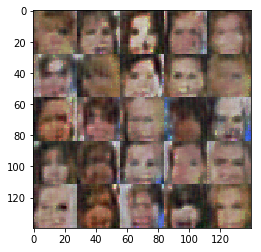

--------------------------------------------------------
Train Step: 940
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.12768e-01, Max |Grad|: 4.65433e-02, Min |Grad|: 3.18323e-12, Mean: -1.70266e-05, Std: 4.39375e-04
G_Grad - Norm: 1.08215e-01,  Max |Grad|: 1.49054e-02, Min |Grad|: 3.63798e-12, Mean: -4.75367e-07, Std: 8.71673e-05
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.5894
--------------------------------------------------------
Train Step: 960
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 4.63719e-01, Max |Grad|: 7.37174e-02, Min |Grad|: 2.04636e-12, Mean: -2.22693e-05, Std: 6.51574e-04
G_Grad - Norm: 1.81916e-01,  Max |Grad|: 4.71899e-02, Min |Grad|: 0.00000e+00, Mean: -2.35918e-07, Std: 1.46536e-04
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.5865
Image: 24


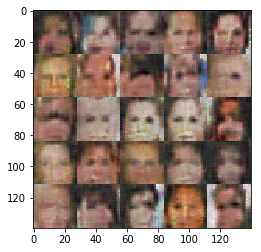

--------------------------------------------------------
Train Step: 980
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.96627e-01, Max |Grad|: 4.25902e-02, Min |Grad|: 3.63798e-12, Mean: -2.11619e-06, Std: 5.57633e-04
G_Grad - Norm: 8.74608e-02,  Max |Grad|: 1.36634e-02, Min |Grad|: 1.81899e-12, Mean: 3.59986e-07, Std: 7.04498e-05
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.5796
--------------------------------------------------------
Train Step: 1000
Batch Size: 128, Learning Rate: 0.0001
D_Grad - Norm: 3.50418e-01, Max |Grad|: 4.94820e-02, Min |Grad|: 6.82121e-13, Mean: -1.14123e-05, Std: 4.92498e-04
G_Grad - Norm: 8.02310e-02,  Max |Grad|: 1.48072e-02, Min |Grad|: 9.09495e-13, Mean: -9.90562e-07, Std: 6.46194e-05
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.5787
Image: 25


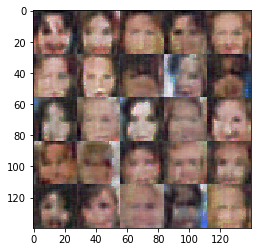

--------------------------------------------------------
Train Step: 1020
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.82928e-01, Max |Grad|: 4.26725e-02, Min |Grad|: 7.38964e-13, Mean: -3.33612e-06, Std: 5.38364e-04
G_Grad - Norm: 6.95187e-02,  Max |Grad|: 8.68794e-03, Min |Grad|: 0.00000e+00, Mean: -3.67234e-07, Std: 5.59967e-05
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 0.5863
--------------------------------------------------------
Train Step: 1040
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.62786e-01, Max |Grad|: 2.58161e-02, Min |Grad|: 5.68434e-12, Mean: -9.26606e-09, Std: 3.69444e-04
G_Grad - Norm: 7.68413e-02,  Max |Grad|: 1.29456e-02, Min |Grad|: 0.00000e+00, Mean: -4.19244e-07, Std: 6.18952e-05
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.5854
Image: 26


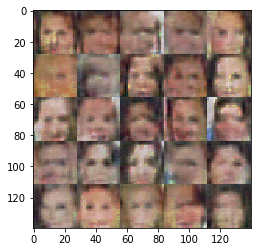

--------------------------------------------------------
Train Step: 1060
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.25419e-01, Max |Grad|: 4.74341e-02, Min |Grad|: 0.00000e+00, Mean: -1.04494e-05, Std: 4.57370e-04
G_Grad - Norm: 6.89751e-02,  Max |Grad|: 1.44833e-02, Min |Grad|: 0.00000e+00, Mean: 5.81227e-07, Std: 5.55574e-05
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.5894
--------------------------------------------------------
Train Step: 1080
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.43489e-01, Max |Grad|: 4.98792e-02, Min |Grad|: 0.00000e+00, Mean: 7.45224e-07, Std: 4.82892e-04
G_Grad - Norm: 7.59950e-02,  Max |Grad|: 1.44924e-02, Min |Grad|: 1.36424e-12, Mean: 1.50450e-07, Std: 6.12149e-05
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.5925
Image: 27


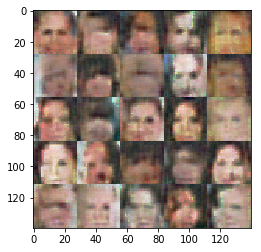

--------------------------------------------------------
Train Step: 1100
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.67280e-01, Max |Grad|: 2.70371e-02, Min |Grad|: 5.68434e-13, Mean: 3.81029e-06, Std: 3.75746e-04
G_Grad - Norm: 7.53862e-02,  Max |Grad|: 1.16239e-02, Min |Grad|: 0.00000e+00, Mean: 2.15485e-08, Std: 6.07248e-05
Epoch 1/2... Discriminator Loss: 1.3490... Generator Loss: 0.5862
--------------------------------------------------------
Train Step: 1120
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.92382e-01, Max |Grad|: 4.30107e-02, Min |Grad|: 0.00000e+00, Mean: -9.64946e-06, Std: 4.10933e-04
G_Grad - Norm: 7.07531e-02,  Max |Grad|: 7.83596e-03, Min |Grad|: 0.00000e+00, Mean: 2.57763e-07, Std: 5.69917e-05
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.5914
Image: 28


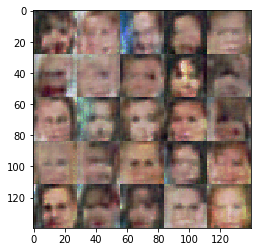

--------------------------------------------------------
Train Step: 1140
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.89665e-01, Max |Grad|: 2.59489e-02, Min |Grad|: 3.75167e-12, Mean: -1.19662e-05, Std: 4.07056e-04
G_Grad - Norm: 7.61748e-02,  Max |Grad|: 7.67119e-03, Min |Grad|: 1.25056e-12, Mean: -2.76827e-07, Std: 6.13592e-05
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.5898
--------------------------------------------------------
Train Step: 1160
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.21141e-01, Max |Grad|: 4.00142e-02, Min |Grad|: 4.54747e-13, Mean: -3.90927e-06, Std: 4.51456e-04
G_Grad - Norm: 7.52379e-02,  Max |Grad|: 9.28074e-03, Min |Grad|: 1.81899e-12, Mean: 8.67579e-08, Std: 6.06051e-05
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.5845
Image: 29


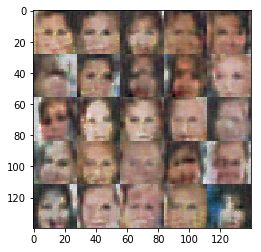

--------------------------------------------------------
Train Step: 1180
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.98789e-01, Max |Grad|: 2.79566e-02, Min |Grad|: 0.00000e+00, Mean: 1.20345e-05, Std: 4.19879e-04
G_Grad - Norm: 6.95187e-02,  Max |Grad|: 9.90378e-03, Min |Grad|: 0.00000e+00, Mean: 5.89885e-07, Std: 5.59951e-05
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.5867
--------------------------------------------------------
Train Step: 1200
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 6.46127e-01, Max |Grad|: 7.77165e-02, Min |Grad|: 1.13687e-13, Mean: -6.01378e-06, Std: 9.08417e-04
G_Grad - Norm: 8.62255e-02,  Max |Grad|: 1.72264e-02, Min |Grad|: 1.15432e-12, Mean: 5.94150e-07, Std: 6.94533e-05
Epoch 1/2... Discriminator Loss: 1.3556... Generator Loss: 0.5938
Image: 30


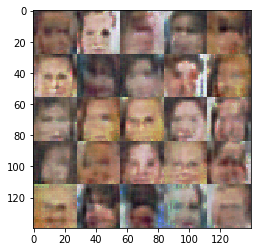

--------------------------------------------------------
Train Step: 1220
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 5.09927e-01, Max |Grad|: 5.50394e-02, Min |Grad|: 4.54747e-13, Mean: 5.27053e-06, Std: 7.16986e-04
G_Grad - Norm: 7.12687e-02,  Max |Grad|: 1.14408e-02, Min |Grad|: 0.00000e+00, Mean: -1.99046e-08, Std: 5.74076e-05
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.5914
--------------------------------------------------------
Train Step: 1240
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.02223e-01, Max |Grad|: 3.17056e-02, Min |Grad|: 1.81899e-12, Mean: -1.07568e-06, Std: 4.24882e-04
G_Grad - Norm: 8.14792e-02,  Max |Grad|: 1.33902e-02, Min |Grad|: 0.00000e+00, Mean: 3.47859e-07, Std: 6.56317e-05
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.5936
Image: 31


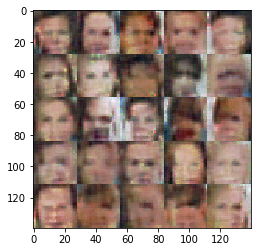

--------------------------------------------------------
Train Step: 1260
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.78520e-01, Max |Grad|: 3.94374e-02, Min |Grad|: 0.00000e+00, Mean: -1.23376e-05, Std: 5.32031e-04
G_Grad - Norm: 8.23347e-02,  Max |Grad|: 1.05670e-02, Min |Grad|: 0.00000e+00, Mean: 3.28125e-07, Std: 6.63210e-05
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.5902
--------------------------------------------------------
Train Step: 1280
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.05216e-01, Max |Grad|: 4.36969e-02, Min |Grad|: 4.54747e-13, Mean: -2.27535e-06, Std: 5.69695e-04
G_Grad - Norm: 7.96297e-02,  Max |Grad|: 1.80831e-02, Min |Grad|: 0.00000e+00, Mean: 5.32270e-07, Std: 6.41403e-05
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.5858
Image: 32


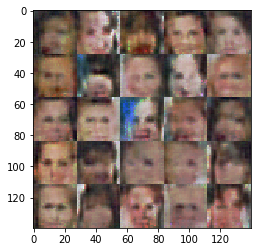

--------------------------------------------------------
Train Step: 1300
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.35998e-01, Max |Grad|: 3.20555e-02, Min |Grad|: 4.54747e-12, Mean: -4.27708e-06, Std: 4.72343e-04
G_Grad - Norm: 7.38593e-02,  Max |Grad|: 1.36554e-02, Min |Grad|: 2.27374e-12, Mean: 1.83585e-07, Std: 5.94943e-05
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.5858
--------------------------------------------------------
Train Step: 1320
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.09111e-01, Max |Grad|: 4.69076e-02, Min |Grad|: 3.18323e-12, Mean: 3.20028e-06, Std: 5.75174e-04
G_Grad - Norm: 1.17280e-01,  Max |Grad|: 3.51006e-02, Min |Grad|: 0.00000e+00, Mean: -3.99903e-07, Std: 9.44700e-05
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.5914
Image: 33


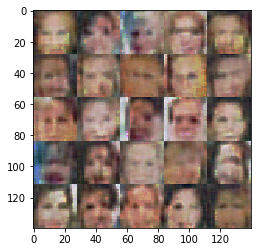

--------------------------------------------------------
Train Step: 1340
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.24364e-01, Max |Grad|: 4.50281e-02, Min |Grad|: 7.27596e-12, Mean: -6.17334e-06, Std: 4.55964e-04
G_Grad - Norm: 8.35814e-02,  Max |Grad|: 9.96246e-03, Min |Grad|: 0.00000e+00, Mean: 1.21717e-07, Std: 6.73259e-05
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 0.5883
--------------------------------------------------------
Train Step: 1360
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.37653e-01, Max |Grad|: 4.50897e-02, Min |Grad|: 7.27596e-12, Mean: -1.14677e-05, Std: 6.15195e-04
G_Grad - Norm: 8.25562e-02,  Max |Grad|: 1.53071e-02, Min |Grad|: 0.00000e+00, Mean: 8.90687e-07, Std: 6.64940e-05
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.5875
Image: 34


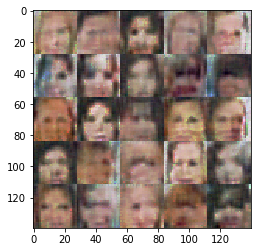

--------------------------------------------------------
Train Step: 1380
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.60194e-01, Max |Grad|: 4.16040e-02, Min |Grad|: 0.00000e+00, Mean: -9.81047e-06, Std: 3.65668e-04
G_Grad - Norm: 7.24041e-02,  Max |Grad|: 1.40960e-02, Min |Grad|: 0.00000e+00, Mean: 4.54953e-07, Std: 5.83206e-05
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.5904
--------------------------------------------------------
Train Step: 1400
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.96168e-01, Max |Grad|: 3.54881e-02, Min |Grad|: 0.00000e+00, Mean: 1.69500e-07, Std: 4.16368e-04
G_Grad - Norm: 7.05364e-02,  Max |Grad|: 6.31355e-03, Min |Grad|: 0.00000e+00, Mean: -1.89584e-07, Std: 5.68179e-05
Epoch 1/2... Discriminator Loss: 1.3520... Generator Loss: 0.5879
Image: 35


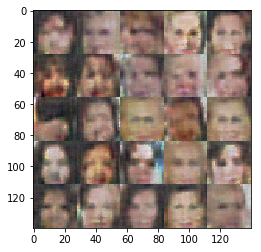

--------------------------------------------------------
Train Step: 1420
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.79626e-01, Max |Grad|: 2.97708e-02, Min |Grad|: 2.24532e-12, Mean: -3.90507e-07, Std: 3.93115e-04
G_Grad - Norm: 7.51687e-02,  Max |Grad|: 8.84948e-03, Min |Grad|: 0.00000e+00, Mean: 1.56309e-07, Std: 6.05491e-05
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.5894
--------------------------------------------------------
Train Step: 1440
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.00717e-01, Max |Grad|: 4.31430e-02, Min |Grad|: 1.00044e-11, Mean: 3.46026e-06, Std: 4.22754e-04
G_Grad - Norm: 7.12612e-02,  Max |Grad|: 1.43077e-02, Min |Grad|: 0.00000e+00, Mean: -2.50118e-07, Std: 5.74014e-05
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.5902
Image: 36


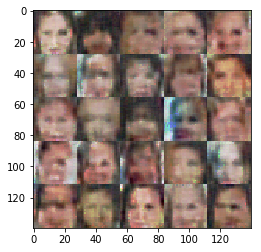

--------------------------------------------------------
Train Step: 1460
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.22939e-01, Max |Grad|: 4.03099e-02, Min |Grad|: 2.27374e-12, Mean: -2.15795e-05, Std: 4.53491e-04
G_Grad - Norm: 9.34630e-02,  Max |Grad|: 2.71641e-02, Min |Grad|: 1.81899e-12, Mean: 7.48736e-07, Std: 7.52818e-05
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.5876
--------------------------------------------------------
Train Step: 1480
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.65708e-01, Max |Grad|: 4.14582e-02, Min |Grad|: 0.00000e+00, Mean: 1.04944e-07, Std: 3.73551e-04
G_Grad - Norm: 8.70167e-02,  Max |Grad|: 2.01639e-02, Min |Grad|: 9.09495e-13, Mean: 5.11144e-07, Std: 7.00912e-05
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.5889
Image: 37


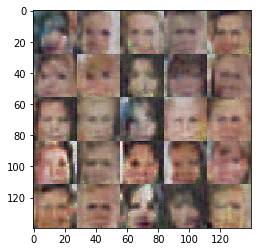

--------------------------------------------------------
Train Step: 1500
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.75580e-01, Max |Grad|: 2.94567e-02, Min |Grad|: 4.02167e-12, Mean: -7.34120e-06, Std: 3.87360e-04
G_Grad - Norm: 7.08758e-02,  Max |Grad|: 1.11354e-02, Min |Grad|: 0.00000e+00, Mean: 6.75216e-07, Std: 5.70871e-05
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.5829
--------------------------------------------------------
Train Step: 1520
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.23829e-01, Max |Grad|: 3.69131e-02, Min |Grad|: 0.00000e+00, Mean: -5.26080e-06, Std: 4.55226e-04
G_Grad - Norm: 7.34024e-02,  Max |Grad|: 1.63128e-02, Min |Grad|: 1.81899e-12, Mean: 6.67851e-07, Std: 5.91227e-05
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.5850
Image: 38


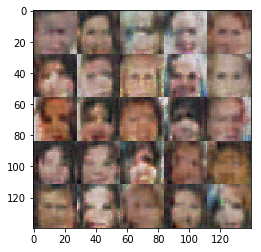

--------------------------------------------------------
Train Step: 1540
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.91595e-01, Max |Grad|: 3.75739e-02, Min |Grad|: 0.00000e+00, Mean: 1.52928e-05, Std: 5.50336e-04
G_Grad - Norm: 7.69643e-02,  Max |Grad|: 1.00261e-02, Min |Grad|: 0.00000e+00, Mean: 4.09296e-07, Std: 6.19946e-05
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.5879
--------------------------------------------------------
Train Step: 1560
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.15443e-01, Max |Grad|: 3.75603e-02, Min |Grad|: 8.64020e-12, Mean: 4.38271e-06, Std: 4.43442e-04
G_Grad - Norm: 8.12710e-02,  Max |Grad|: 1.22884e-02, Min |Grad|: 2.72848e-12, Mean: -4.42842e-07, Std: 6.54634e-05
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.5970
Image: 39


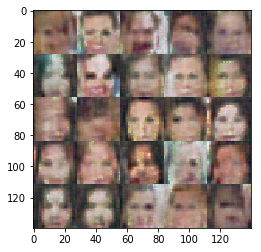

--------------------------------------------------------
Train Step: 1580
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.83968e-01, Max |Grad|: 3.71087e-02, Min |Grad|: 3.18323e-12, Mean: -9.96428e-06, Std: 3.99096e-04
G_Grad - Norm: 7.75462e-02,  Max |Grad|: 1.37029e-02, Min |Grad|: 0.00000e+00, Mean: -1.17244e-07, Std: 6.24646e-05
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 0.5893
--------------------------------------------------------
Train Step: 1600
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.66160e-01, Max |Grad|: 6.57678e-02, Min |Grad|: 0.00000e+00, Mean: -3.30012e-06, Std: 5.14804e-04
G_Grad - Norm: 8.58108e-02,  Max |Grad|: 1.89369e-02, Min |Grad|: 0.00000e+00, Mean: 1.62522e-07, Std: 6.91214e-05
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.5906
Image: 40


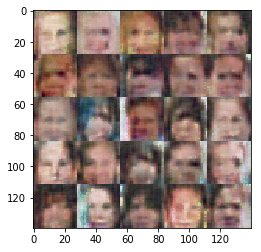

--------------------------------------------------------
Train Step: 1620
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.71668e-01, Max |Grad|: 2.90961e-02, Min |Grad|: 2.27374e-13, Mean: 2.19736e-07, Std: 5.22547e-04
G_Grad - Norm: 7.06050e-02,  Max |Grad|: 1.13173e-02, Min |Grad|: 0.00000e+00, Mean: -9.27486e-07, Std: 5.68655e-05
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.5861
--------------------------------------------------------
Train Step: 1640
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.05961e-01, Max |Grad|: 3.38204e-02, Min |Grad|: 6.36646e-12, Mean: 3.17678e-06, Std: 4.30126e-04
G_Grad - Norm: 7.43512e-02,  Max |Grad|: 1.12869e-02, Min |Grad|: 0.00000e+00, Mean: -1.75207e-07, Std: 5.98908e-05
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 0.5869
Image: 41


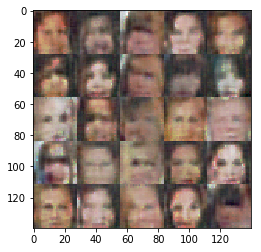

--------------------------------------------------------
Train Step: 1660
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.99458e-01, Max |Grad|: 4.13928e-02, Min |Grad|: 0.00000e+00, Mean: -5.63448e-06, Std: 4.20954e-04
G_Grad - Norm: 6.30456e-02,  Max |Grad|: 7.44846e-03, Min |Grad|: 2.72848e-12, Mean: -1.52162e-07, Std: 5.07837e-05
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.5913
--------------------------------------------------------
Train Step: 1680
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.02354e-01, Max |Grad|: 2.79015e-02, Min |Grad|: 3.41061e-12, Mean: 4.27843e-06, Std: 4.25042e-04
G_Grad - Norm: 7.60606e-02,  Max |Grad|: 1.23257e-02, Min |Grad|: 2.72848e-12, Mean: 6.37132e-07, Std: 6.12644e-05
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.5922
Image: 42


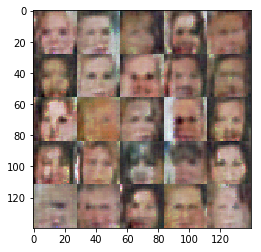

--------------------------------------------------------
Train Step: 1700
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.80803e-01, Max |Grad|: 4.60521e-02, Min |Grad|: 0.00000e+00, Mean: 5.85162e-06, Std: 3.94725e-04
G_Grad - Norm: 8.43335e-02,  Max |Grad|: 1.95652e-02, Min |Grad|: 0.00000e+00, Mean: 3.41965e-07, Std: 6.79310e-05
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.5868
--------------------------------------------------------
Train Step: 1720
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.80733e-01, Max |Grad|: 2.07413e-02, Min |Grad|: 9.09495e-13, Mean: 1.00085e-05, Std: 3.94548e-04
G_Grad - Norm: 7.07011e-02,  Max |Grad|: 6.95377e-03, Min |Grad|: 0.00000e+00, Mean: 2.57240e-07, Std: 5.69503e-05
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.5845
Image: 43


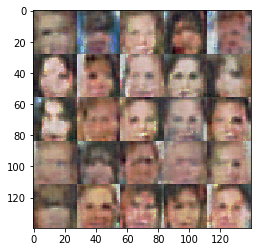

--------------------------------------------------------
Train Step: 1740
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.24626e-01, Max |Grad|: 4.65511e-02, Min |Grad|: 9.09495e-13, Mean: 1.04639e-05, Std: 5.96892e-04
G_Grad - Norm: 7.60568e-02,  Max |Grad|: 1.25023e-02, Min |Grad|: 2.72848e-12, Mean: 8.17609e-08, Std: 6.12645e-05
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.5879
--------------------------------------------------------
Train Step: 1760
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.14053e-01, Max |Grad|: 4.70783e-02, Min |Grad|: 2.04636e-12, Mean: -5.69196e-06, Std: 4.41477e-04
G_Grad - Norm: 8.44697e-02,  Max |Grad|: 1.66901e-02, Min |Grad|: 9.09495e-13, Mean: 6.90546e-07, Std: 6.80380e-05
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.5861
Image: 44


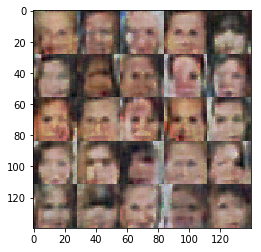

--------------------------------------------------------
Train Step: 1780
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.13808e-01, Max |Grad|: 2.23981e-02, Min |Grad|: 0.00000e+00, Mean: 1.67926e-05, Std: 4.40847e-04
G_Grad - Norm: 7.48562e-02,  Max |Grad|: 1.36128e-02, Min |Grad|: 0.00000e+00, Mean: 2.22065e-07, Std: 6.02971e-05
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.5935
--------------------------------------------------------
Train Step: 1800
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.97624e-01, Max |Grad|: 4.27185e-02, Min |Grad|: 1.76215e-12, Mean: 1.84940e-06, Std: 4.18411e-04
G_Grad - Norm: 7.24492e-02,  Max |Grad|: 8.59210e-03, Min |Grad|: 0.00000e+00, Mean: 6.49083e-07, Std: 5.83552e-05
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.5913
Image: 45


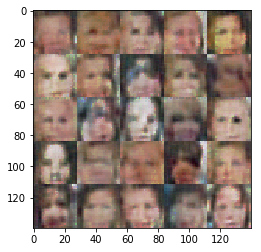

--------------------------------------------------------
Train Step: 1820
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.85863e-01, Max |Grad|: 3.61420e-02, Min |Grad|: 3.63798e-12, Mean: 4.71373e-06, Std: 4.01858e-04
G_Grad - Norm: 8.08355e-02,  Max |Grad|: 1.05751e-02, Min |Grad|: 0.00000e+00, Mean: 1.70651e-07, Std: 6.51137e-05
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.5937
--------------------------------------------------------
Train Step: 1840
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.32704e-01, Max |Grad|: 3.41040e-02, Min |Grad|: 1.54614e-11, Mean: -1.38855e-05, Std: 4.67526e-04
G_Grad - Norm: 7.05263e-02,  Max |Grad|: 1.27574e-02, Min |Grad|: 1.81899e-12, Mean: -1.45190e-07, Std: 5.68097e-05
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.5898
Image: 46


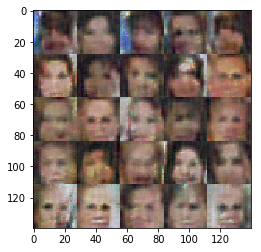

--------------------------------------------------------
Train Step: 1860
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.98884e-01, Max |Grad|: 2.08539e-02, Min |Grad|: 8.18545e-12, Mean: 1.65072e-05, Std: 5.60566e-04
G_Grad - Norm: 6.80168e-02,  Max |Grad|: 1.20114e-02, Min |Grad|: 0.00000e+00, Mean: 5.88111e-07, Std: 5.47853e-05
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.5864
--------------------------------------------------------
Train Step: 1880
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.90928e-01, Max |Grad|: 3.25938e-02, Min |Grad|: 7.27596e-12, Mean: 4.67458e-06, Std: 4.08974e-04
G_Grad - Norm: 7.27264e-02,  Max |Grad|: 7.79913e-03, Min |Grad|: 0.00000e+00, Mean: 5.30538e-07, Std: 5.85795e-05
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.5886
Image: 47


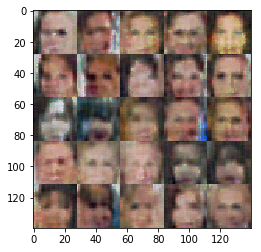

--------------------------------------------------------
Train Step: 1900
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.73168e-01, Max |Grad|: 4.26273e-02, Min |Grad|: 4.60432e-12, Mean: 5.82398e-07, Std: 5.24657e-04
G_Grad - Norm: 8.42720e-02,  Max |Grad|: 1.91952e-02, Min |Grad|: 0.00000e+00, Mean: 1.34547e-06, Std: 6.78687e-05
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 0.5923
--------------------------------------------------------
Train Step: 1920
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.99659e-01, Max |Grad|: 4.48625e-02, Min |Grad|: 8.18545e-12, Mean: -6.90978e-06, Std: 5.61845e-04
G_Grad - Norm: 7.46248e-02,  Max |Grad|: 1.24575e-02, Min |Grad|: 0.00000e+00, Mean: -5.87474e-07, Std: 6.01086e-05
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.5865
Image: 48


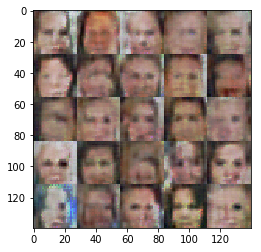

--------------------------------------------------------
Train Step: 1940
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.47600e-01, Max |Grad|: 5.42243e-02, Min |Grad|: 0.00000e+00, Mean: -8.75271e-06, Std: 6.29228e-04
G_Grad - Norm: 6.83497e-02,  Max |Grad|: 7.17583e-03, Min |Grad|: 0.00000e+00, Mean: 4.65623e-07, Std: 5.50545e-05
Epoch 2/2... Discriminator Loss: 1.3521... Generator Loss: 0.5919
--------------------------------------------------------
Train Step: 1960
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.13415e-01, Max |Grad|: 3.15511e-02, Min |Grad|: 1.98952e-12, Mean: -1.15683e-06, Std: 4.40610e-04
G_Grad - Norm: 8.40774e-02,  Max |Grad|: 1.74718e-02, Min |Grad|: 0.00000e+00, Mean: 3.03572e-07, Std: 6.77247e-05
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.5869
Image: 49


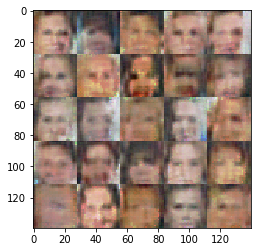

--------------------------------------------------------
Train Step: 1980
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.80450e-01, Max |Grad|: 3.17355e-02, Min |Grad|: 2.04636e-12, Mean: -2.42956e-07, Std: 5.34894e-04
G_Grad - Norm: 8.82929e-02,  Max |Grad|: 2.36576e-02, Min |Grad|: 0.00000e+00, Mean: 1.80202e-07, Std: 7.11208e-05
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.5878
--------------------------------------------------------
Train Step: 2000
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.43760e-01, Max |Grad|: 2.98834e-02, Min |Grad|: 4.32010e-12, Mean: 2.88140e-07, Std: 4.83272e-04
G_Grad - Norm: 7.68554e-02,  Max |Grad|: 1.62130e-02, Min |Grad|: 3.18323e-12, Mean: 1.50057e-07, Std: 6.19077e-05
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 0.5920
Image: 50


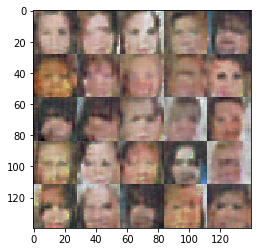

--------------------------------------------------------
Train Step: 2020
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.41291e-01, Max |Grad|: 4.55472e-02, Min |Grad|: 1.81899e-12, Mean: 8.50480e-06, Std: 6.20369e-04
G_Grad - Norm: 6.19549e-02,  Max |Grad|: 8.85926e-03, Min |Grad|: 3.63798e-12, Mean: -4.31348e-08, Std: 4.99056e-05
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.5866
--------------------------------------------------------
Train Step: 2040
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.31837e-01, Max |Grad|: 4.85937e-02, Min |Grad|: 2.72848e-12, Mean: 6.71702e-06, Std: 4.66466e-04
G_Grad - Norm: 7.40584e-02,  Max |Grad|: 1.35894e-02, Min |Grad|: 0.00000e+00, Mean: 1.12305e-07, Std: 5.96546e-05
Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.5883
Image: 51


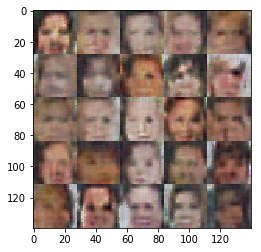

--------------------------------------------------------
Train Step: 2060
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.28500e-01, Max |Grad|: 4.46993e-02, Min |Grad|: 0.00000e+00, Mean: -1.85383e-05, Std: 6.02151e-04
G_Grad - Norm: 6.88448e-02,  Max |Grad|: 1.14556e-02, Min |Grad|: 0.00000e+00, Mean: -3.19062e-07, Std: 5.54545e-05
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.5919
--------------------------------------------------------
Train Step: 2080
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.33136e-01, Max |Grad|: 2.91523e-02, Min |Grad|: 0.00000e+00, Mean: 1.49341e-05, Std: 4.68101e-04
G_Grad - Norm: 8.08582e-02,  Max |Grad|: 1.98871e-02, Min |Grad|: 0.00000e+00, Mean: 4.13351e-07, Std: 6.51307e-05
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.5887
Image: 52


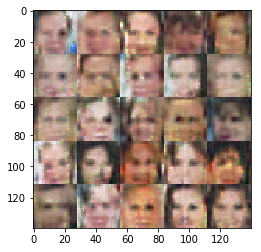

--------------------------------------------------------
Train Step: 2100
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.73324e-01, Max |Grad|: 2.91772e-02, Min |Grad|: 6.36646e-12, Mean: 9.42761e-07, Std: 3.84258e-04
G_Grad - Norm: 7.13180e-02,  Max |Grad|: 1.26070e-02, Min |Grad|: 0.00000e+00, Mean: 7.63187e-08, Std: 5.74476e-05
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.5897
--------------------------------------------------------
Train Step: 2120
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.89686e-01, Max |Grad|: 2.82605e-02, Min |Grad|: 4.54747e-13, Mean: -3.51737e-06, Std: 4.07239e-04
G_Grad - Norm: 7.46124e-02,  Max |Grad|: 1.03733e-02, Min |Grad|: 1.13687e-12, Mean: 3.98972e-07, Std: 6.01000e-05
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.5870
Image: 53


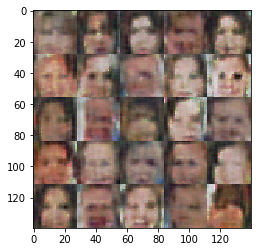

--------------------------------------------------------
Train Step: 2140
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.60861e-01, Max |Grad|: 2.47170e-02, Min |Grad|: 2.27374e-13, Mean: -3.18706e-06, Std: 3.66725e-04
G_Grad - Norm: 7.87208e-02,  Max |Grad|: 1.35606e-02, Min |Grad|: 0.00000e+00, Mean: -2.75584e-07, Std: 6.34100e-05
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.5890
--------------------------------------------------------
Train Step: 2160
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 5.39729e-01, Max |Grad|: 3.93152e-02, Min |Grad|: 1.59162e-12, Mean: -2.76978e-05, Std: 7.58392e-04
G_Grad - Norm: 8.35899e-02,  Max |Grad|: 1.04026e-02, Min |Grad|: 0.00000e+00, Mean: 9.39994e-07, Std: 6.73262e-05
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.5900
Image: 54


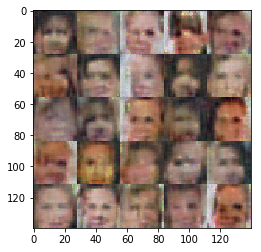

--------------------------------------------------------
Train Step: 2180
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.25431e-01, Max |Grad|: 4.87604e-02, Min |Grad|: 1.27329e-11, Mean: -2.94777e-06, Std: 5.98117e-04
G_Grad - Norm: 9.68590e-02,  Max |Grad|: 2.50475e-02, Min |Grad|: 9.09495e-13, Mean: -4.33908e-07, Std: 7.80200e-05
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.5938
--------------------------------------------------------
Train Step: 2200
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.63483e-01, Max |Grad|: 5.83072e-02, Min |Grad|: 1.94404e-11, Mean: 1.59519e-05, Std: 6.51401e-04
G_Grad - Norm: 7.16859e-02,  Max |Grad|: 1.34428e-02, Min |Grad|: 0.00000e+00, Mean: -5.53551e-07, Std: 5.77413e-05
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.5880
Image: 55


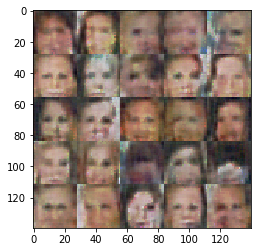

--------------------------------------------------------
Train Step: 2220
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.47885e-01, Max |Grad|: 5.27708e-02, Min |Grad|: 1.45519e-11, Mean: 4.03714e-06, Std: 6.29677e-04
G_Grad - Norm: 7.64352e-02,  Max |Grad|: 1.37584e-02, Min |Grad|: 0.00000e+00, Mean: 7.20468e-07, Std: 6.15652e-05
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.5901
--------------------------------------------------------
Train Step: 2240
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.73720e-01, Max |Grad|: 3.48639e-02, Min |Grad|: 4.09273e-12, Mean: -2.23127e-05, Std: 5.24957e-04
G_Grad - Norm: 8.96286e-02,  Max |Grad|: 2.48977e-02, Min |Grad|: 4.54747e-13, Mean: 4.94406e-08, Std: 7.21967e-05
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.5873
Image: 56


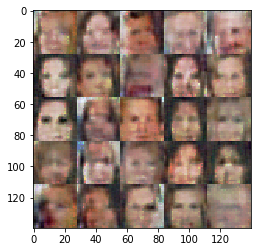

--------------------------------------------------------
Train Step: 2260
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.24678e-01, Max |Grad|: 3.80726e-02, Min |Grad|: 8.24230e-13, Mean: -2.40594e-05, Std: 5.96564e-04
G_Grad - Norm: 1.04695e-01,  Max |Grad|: 2.38666e-02, Min |Grad|: 0.00000e+00, Mean: -7.22778e-07, Std: 8.43301e-05
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.5799
--------------------------------------------------------
Train Step: 2280
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.26420e-01, Max |Grad|: 3.24092e-02, Min |Grad|: 3.18323e-12, Mean: 6.79111e-06, Std: 4.58846e-04
G_Grad - Norm: 7.60667e-02,  Max |Grad|: 2.30186e-02, Min |Grad|: 0.00000e+00, Mean: -7.37484e-07, Std: 6.12680e-05
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.5907
Image: 57


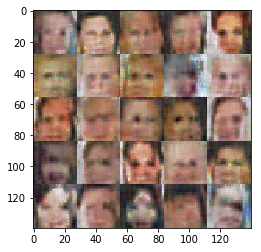

--------------------------------------------------------
Train Step: 2300
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.64681e-01, Max |Grad|: 4.19112e-02, Min |Grad|: 0.00000e+00, Mean: 3.76309e-06, Std: 5.12699e-04
G_Grad - Norm: 8.34170e-02,  Max |Grad|: 2.32344e-02, Min |Grad|: 0.00000e+00, Mean: 3.98941e-07, Std: 6.71923e-05
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.5913
--------------------------------------------------------
Train Step: 2320
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.95690e-01, Max |Grad|: 3.25714e-02, Min |Grad|: 0.00000e+00, Mean: 5.58214e-06, Std: 4.15657e-04
G_Grad - Norm: 9.36155e-02,  Max |Grad|: 2.16713e-02, Min |Grad|: 0.00000e+00, Mean: -2.63109e-09, Std: 7.54085e-05
Epoch 2/2... Discriminator Loss: 1.3537... Generator Loss: 0.5914
Image: 58


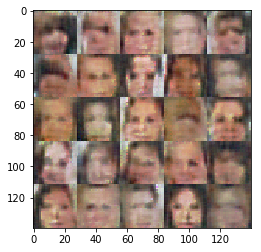

--------------------------------------------------------
Train Step: 2340
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.69268e-01, Max |Grad|: 2.86247e-02, Min |Grad|: 0.00000e+00, Mean: 6.76777e-06, Std: 5.19136e-04
G_Grad - Norm: 8.29765e-02,  Max |Grad|: 2.51886e-02, Min |Grad|: 0.00000e+00, Mean: -9.61459e-07, Std: 6.68322e-05
Epoch 2/2... Discriminator Loss: 1.3515... Generator Loss: 0.5904
--------------------------------------------------------
Train Step: 2360
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 5.39806e-01, Max |Grad|: 3.76738e-02, Min |Grad|: 0.00000e+00, Mean: 1.12583e-05, Std: 7.58939e-04
G_Grad - Norm: 7.49134e-02,  Max |Grad|: 8.58732e-03, Min |Grad|: 2.72848e-12, Mean: 5.18717e-07, Std: 6.03412e-05
Epoch 2/2... Discriminator Loss: 1.3501... Generator Loss: 0.5900
Image: 59


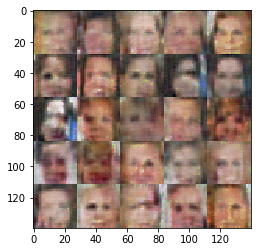

--------------------------------------------------------
Train Step: 2380
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.35807e-01, Max |Grad|: 4.66348e-02, Min |Grad|: 1.13687e-12, Mean: -2.16920e-06, Std: 4.72086e-04
G_Grad - Norm: 7.04006e-02,  Max |Grad|: 1.11998e-02, Min |Grad|: 0.00000e+00, Mean: 4.85890e-07, Std: 5.67064e-05
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.5925
--------------------------------------------------------
Train Step: 2400
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.38271e-01, Max |Grad|: 3.94562e-02, Min |Grad|: 7.04858e-12, Mean: 8.17500e-06, Std: 4.75488e-04
G_Grad - Norm: 1.04941e-01,  Max |Grad|: 1.36543e-02, Min |Grad|: 0.00000e+00, Mean: -5.15583e-08, Std: 8.45314e-05
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.5857
Image: 60


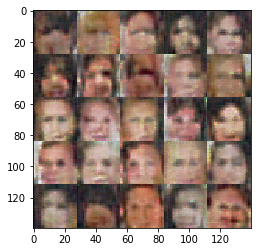

--------------------------------------------------------
Train Step: 2420
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.12242e-01, Max |Grad|: 2.84742e-02, Min |Grad|: 4.54747e-13, Mean: -3.42105e-06, Std: 5.79569e-04
G_Grad - Norm: 9.92437e-02,  Max |Grad|: 3.11544e-02, Min |Grad|: 0.00000e+00, Mean: 6.42158e-08, Std: 7.99419e-05
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.5933
--------------------------------------------------------
Train Step: 2440
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.31992e-01, Max |Grad|: 4.32119e-02, Min |Grad|: 1.81899e-12, Mean: -2.27934e-06, Std: 6.07341e-04
G_Grad - Norm: 7.48684e-02,  Max |Grad|: 1.76785e-02, Min |Grad|: 1.59162e-12, Mean: 3.70322e-08, Std: 6.03073e-05
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.5890
Image: 61


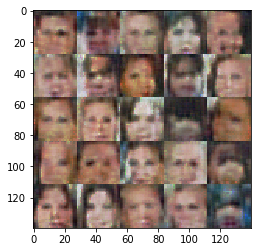

--------------------------------------------------------
Train Step: 2460
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.15938e-01, Max |Grad|: 4.33936e-02, Min |Grad|: 0.00000e+00, Mean: 1.26180e-05, Std: 4.43982e-04
G_Grad - Norm: 7.81294e-02,  Max |Grad|: 1.94269e-02, Min |Grad|: 1.81899e-12, Mean: 5.83326e-07, Std: 6.29314e-05
Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 0.5832
--------------------------------------------------------
Train Step: 2480
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.20891e-01, Max |Grad|: 2.74642e-02, Min |Grad|: 1.81899e-12, Mean: -3.74710e-06, Std: 4.51109e-04
G_Grad - Norm: 8.05854e-02,  Max |Grad|: 8.61392e-03, Min |Grad|: 0.00000e+00, Mean: 2.77234e-07, Std: 6.49120e-05
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.5928
Image: 62


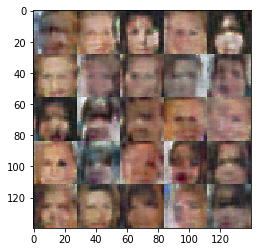

--------------------------------------------------------
Train Step: 2500
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.35050e-01, Max |Grad|: 3.61336e-02, Min |Grad|: 9.09495e-13, Mean: -4.50205e-06, Std: 4.71009e-04
G_Grad - Norm: 8.17892e-02,  Max |Grad|: 1.95303e-02, Min |Grad|: 0.00000e+00, Mean: -7.11007e-08, Std: 6.58822e-05
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.5840
--------------------------------------------------------
Train Step: 2520
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.99956e-01, Max |Grad|: 3.87954e-02, Min |Grad|: 4.54747e-13, Mean: 1.22607e-05, Std: 4.21514e-04
G_Grad - Norm: 7.21358e-02,  Max |Grad|: 1.47822e-02, Min |Grad|: 0.00000e+00, Mean: 2.39803e-07, Std: 5.81058e-05
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.5882
Image: 63


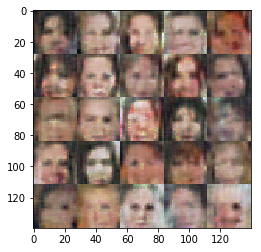

--------------------------------------------------------
Train Step: 2540
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.49313e-01, Max |Grad|: 3.96439e-02, Min |Grad|: 0.00000e+00, Mean: -6.65703e-06, Std: 4.91036e-04
G_Grad - Norm: 7.43018e-02,  Max |Grad|: 1.03179e-02, Min |Grad|: 0.00000e+00, Mean: 1.52443e-07, Std: 5.98507e-05
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.5860
--------------------------------------------------------
Train Step: 2560
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.22890e-01, Max |Grad|: 4.10106e-02, Min |Grad|: 7.27596e-12, Mean: -8.94849e-06, Std: 4.53846e-04
G_Grad - Norm: 9.04970e-02,  Max |Grad|: 1.27613e-02, Min |Grad|: 0.00000e+00, Mean: -3.84763e-07, Std: 7.28956e-05
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.5887
Image: 64


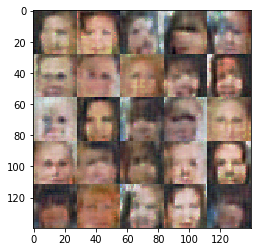

--------------------------------------------------------
Train Step: 2580
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.17553e-01, Max |Grad|: 3.98521e-02, Min |Grad|: 1.25056e-12, Mean: -7.46211e-06, Std: 4.46369e-04
G_Grad - Norm: 6.95382e-02,  Max |Grad|: 6.76512e-03, Min |Grad|: 4.54747e-13, Mean: 8.28750e-08, Std: 5.60139e-05
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.5928
--------------------------------------------------------
Train Step: 2600
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.44779e-01, Max |Grad|: 5.22810e-02, Min |Grad|: 6.36646e-12, Mean: 7.47062e-06, Std: 4.84647e-04
G_Grad - Norm: 7.29538e-02,  Max |Grad|: 1.20259e-02, Min |Grad|: 0.00000e+00, Mean: 1.72544e-07, Std: 5.87652e-05
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 0.5908
Image: 65


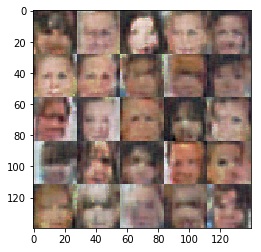

--------------------------------------------------------
Train Step: 2620
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.28724e-01, Max |Grad|: 3.89551e-02, Min |Grad|: 1.81899e-12, Mean: -6.40934e-08, Std: 4.62139e-04
G_Grad - Norm: 7.03705e-02,  Max |Grad|: 1.31877e-02, Min |Grad|: 0.00000e+00, Mean: -3.77867e-08, Std: 5.66844e-05
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.5875
--------------------------------------------------------
Train Step: 2640
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.68401e-01, Max |Grad|: 4.91559e-02, Min |Grad|: 0.00000e+00, Mean: -9.41137e-06, Std: 5.17878e-04
G_Grad - Norm: 1.13689e-01,  Max |Grad|: 4.26162e-02, Min |Grad|: 0.00000e+00, Mean: 4.61550e-07, Std: 9.15765e-05
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.5911
Image: 66


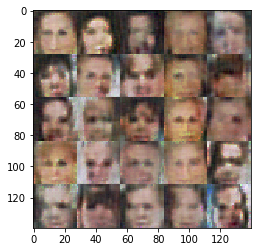

--------------------------------------------------------
Train Step: 2660
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 5.44720e-01, Max |Grad|: 7.13138e-02, Min |Grad|: 0.00000e+00, Mean: 6.41625e-06, Std: 7.65863e-04
G_Grad - Norm: 8.65921e-02,  Max |Grad|: 1.65145e-02, Min |Grad|: 1.81899e-12, Mean: 5.28252e-07, Std: 6.97491e-05
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.5912
--------------------------------------------------------
Train Step: 2680
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.83865e-01, Max |Grad|: 6.96217e-02, Min |Grad|: 1.09139e-11, Mean: -4.82335e-06, Std: 5.39663e-04
G_Grad - Norm: 6.83104e-02,  Max |Grad|: 9.34997e-03, Min |Grad|: 0.00000e+00, Mean: 5.74460e-09, Std: 5.50252e-05
Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.5838
Image: 67


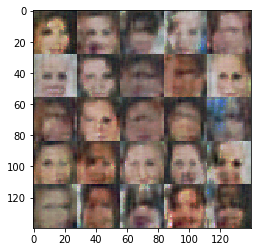

--------------------------------------------------------
Train Step: 2700
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 5.56090e-01, Max |Grad|: 7.04615e-02, Min |Grad|: 1.86446e-11, Mean: 2.70454e-06, Std: 7.81856e-04
G_Grad - Norm: 7.58940e-02,  Max |Grad|: 1.18925e-02, Min |Grad|: 0.00000e+00, Mean: 3.14498e-07, Std: 6.11326e-05
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.5908
--------------------------------------------------------
Train Step: 2720
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.31680e-01, Max |Grad|: 3.05276e-02, Min |Grad|: 4.09273e-12, Mean: 1.52632e-05, Std: 4.66039e-04
G_Grad - Norm: 7.83104e-02,  Max |Grad|: 1.06584e-02, Min |Grad|: 0.00000e+00, Mean: 2.89592e-07, Std: 6.30790e-05
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.5866
Image: 68


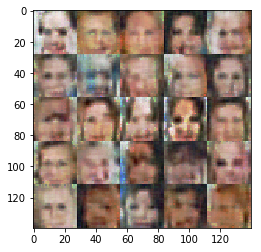

--------------------------------------------------------
Train Step: 2740
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.67853e-01, Max |Grad|: 3.52643e-02, Min |Grad|: 9.09495e-13, Mean: 9.14681e-06, Std: 5.17087e-04
G_Grad - Norm: 7.11286e-02,  Max |Grad|: 7.58945e-03, Min |Grad|: 9.09495e-13, Mean: 1.12150e-08, Std: 5.72951e-05
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.5896
--------------------------------------------------------
Train Step: 2760
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.32372e-01, Max |Grad|: 3.12606e-02, Min |Grad|: 3.63798e-12, Mean: 7.04963e-06, Std: 4.67213e-04
G_Grad - Norm: 7.48061e-02,  Max |Grad|: 8.08363e-03, Min |Grad|: 0.00000e+00, Mean: -3.83005e-08, Std: 6.02573e-05
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.5852
Image: 69


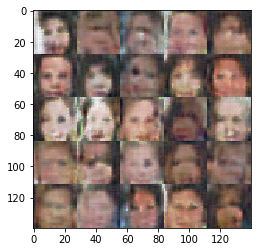

--------------------------------------------------------
Train Step: 2780
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.34713e-01, Max |Grad|: 4.46125e-02, Min |Grad|: 5.45697e-12, Mean: 9.43575e-07, Std: 4.70556e-04
G_Grad - Norm: 7.42362e-02,  Max |Grad|: 1.23551e-02, Min |Grad|: 1.81899e-12, Mean: -1.48102e-07, Std: 5.97979e-05
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.5900
--------------------------------------------------------
Train Step: 2800
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.63299e-01, Max |Grad|: 3.57297e-02, Min |Grad|: 3.63798e-12, Mean: -4.69496e-06, Std: 5.10757e-04
G_Grad - Norm: 7.10911e-02,  Max |Grad|: 7.46004e-03, Min |Grad|: 1.81899e-12, Mean: -1.52586e-08, Std: 5.72647e-05
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.5875
Image: 70


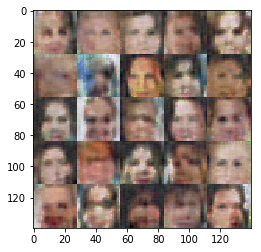

--------------------------------------------------------
Train Step: 2820
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.82766e-01, Max |Grad|: 5.88696e-02, Min |Grad|: 3.41061e-12, Mean: 8.55469e-06, Std: 6.78661e-04
G_Grad - Norm: 7.56713e-02,  Max |Grad|: 1.09200e-02, Min |Grad|: 0.00000e+00, Mean: 3.61733e-07, Std: 6.09532e-05
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.5894
--------------------------------------------------------
Train Step: 2840
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.85257e-01, Max |Grad|: 3.54651e-02, Min |Grad|: 3.18323e-12, Mean: -3.20232e-06, Std: 5.41625e-04
G_Grad - Norm: 7.26807e-02,  Max |Grad|: 1.45505e-02, Min |Grad|: 0.00000e+00, Mean: -3.50541e-08, Std: 5.85451e-05
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 0.5935
Image: 71


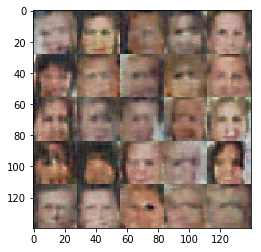

--------------------------------------------------------
Train Step: 2860
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.82296e-01, Max |Grad|: 3.21159e-02, Min |Grad|: 9.09495e-13, Mean: -8.64554e-06, Std: 5.37407e-04
G_Grad - Norm: 8.34498e-02,  Max |Grad|: 2.21562e-02, Min |Grad|: 0.00000e+00, Mean: -2.25414e-07, Std: 6.72197e-05
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.5866
--------------------------------------------------------
Train Step: 2880
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.96992e-01, Max |Grad|: 3.81779e-02, Min |Grad|: 3.63798e-12, Mean: 7.41652e-06, Std: 4.17462e-04
G_Grad - Norm: 7.58154e-02,  Max |Grad|: 8.51289e-03, Min |Grad|: 0.00000e+00, Mean: 2.89361e-07, Std: 6.10695e-05
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.5872
Image: 72


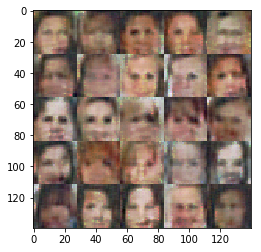

--------------------------------------------------------
Train Step: 2900
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.62938e-01, Max |Grad|: 2.60458e-02, Min |Grad|: 2.27374e-13, Mean: 1.24885e-05, Std: 5.10121e-04
G_Grad - Norm: 1.16391e-01,  Max |Grad|: 3.05097e-02, Min |Grad|: 0.00000e+00, Mean: 5.77009e-07, Std: 9.37525e-05
Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.5916
--------------------------------------------------------
Train Step: 2920
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.50063e-01, Max |Grad|: 2.98319e-02, Min |Grad|: 0.00000e+00, Mean: -1.40358e-05, Std: 4.91930e-04
G_Grad - Norm: 7.73107e-02,  Max |Grad|: 1.24106e-02, Min |Grad|: 0.00000e+00, Mean: 7.89172e-07, Std: 6.22697e-05
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.5857
Image: 73


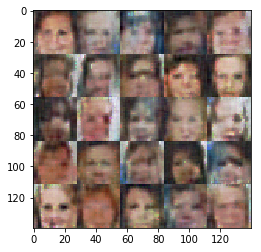

--------------------------------------------------------
Train Step: 2940
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.44900e-01, Max |Grad|: 5.10247e-02, Min |Grad|: 0.00000e+00, Mean: 1.24893e-05, Std: 4.84715e-04
G_Grad - Norm: 9.98467e-02,  Max |Grad|: 2.93201e-02, Min |Grad|: 0.00000e+00, Mean: 5.37032e-07, Std: 8.04260e-05
Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 0.5948
--------------------------------------------------------
Train Step: 2960
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.85112e-01, Max |Grad|: 2.86246e-02, Min |Grad|: 6.82121e-13, Mean: 8.82720e-06, Std: 5.41376e-04
G_Grad - Norm: 6.84448e-02,  Max |Grad|: 8.22768e-03, Min |Grad|: 2.72848e-12, Mean: 3.80624e-07, Std: 5.51319e-05
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.5906
Image: 74


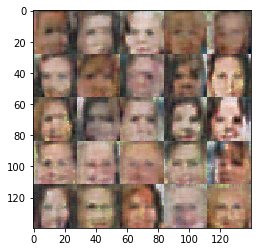

--------------------------------------------------------
Train Step: 2980
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 5.99286e-01, Max |Grad|: 6.25456e-02, Min |Grad|: 1.05729e-11, Mean: -5.22941e-06, Std: 8.42568e-04
G_Grad - Norm: 7.50110e-02,  Max |Grad|: 1.74890e-02, Min |Grad|: 0.00000e+00, Mean: 1.64028e-07, Std: 6.04220e-05
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.5917
--------------------------------------------------------
Train Step: 3000
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.74344e-01, Max |Grad|: 3.99167e-02, Min |Grad|: 1.81899e-12, Mean: 1.25147e-05, Std: 5.26147e-04
G_Grad - Norm: 7.46029e-02,  Max |Grad|: 9.31947e-03, Min |Grad|: 2.95586e-12, Mean: -2.84216e-07, Std: 6.00927e-05
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.5858
Image: 75


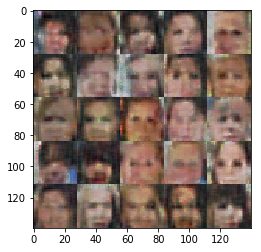

--------------------------------------------------------
Train Step: 3020
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.96059e-01, Max |Grad|: 4.13959e-02, Min |Grad|: 0.00000e+00, Mean: 1.87558e-05, Std: 6.97150e-04
G_Grad - Norm: 7.93567e-02,  Max |Grad|: 1.32909e-02, Min |Grad|: 0.00000e+00, Mean: 1.18240e-07, Std: 6.39230e-05
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.5862
--------------------------------------------------------
Train Step: 3040
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.18158e-01, Max |Grad|: 3.67554e-02, Min |Grad|: 4.54747e-13, Mean: 9.33660e-07, Std: 4.47281e-04
G_Grad - Norm: 7.26682e-02,  Max |Grad|: 1.04482e-02, Min |Grad|: 2.88933e-12, Mean: 1.69531e-08, Std: 5.85352e-05
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.5922
Image: 76


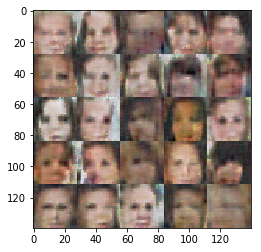

--------------------------------------------------------
Train Step: 3060
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.97426e-01, Max |Grad|: 4.54375e-02, Min |Grad|: 3.63798e-12, Mean: 1.97322e-05, Std: 5.58387e-04
G_Grad - Norm: 7.93537e-02,  Max |Grad|: 1.94065e-02, Min |Grad|: 1.81899e-12, Mean: -6.31027e-08, Std: 6.39205e-05
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.5926
--------------------------------------------------------
Train Step: 3080
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.13239e-01, Max |Grad|: 2.83420e-02, Min |Grad|: 3.41061e-13, Mean: -3.91706e-06, Std: 5.80970e-04
G_Grad - Norm: 8.12566e-02,  Max |Grad|: 1.02454e-02, Min |Grad|: 0.00000e+00, Mean: -2.21221e-07, Std: 6.54529e-05
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.5800
Image: 77


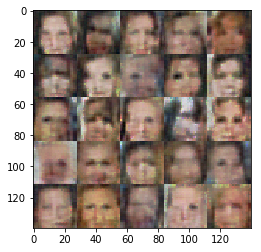

--------------------------------------------------------
Train Step: 3100
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 4.29144e-01, Max |Grad|: 5.46572e-02, Min |Grad|: 5.00222e-12, Mean: 1.19281e-05, Std: 6.03219e-04
G_Grad - Norm: 7.94914e-02,  Max |Grad|: 1.42687e-02, Min |Grad|: 0.00000e+00, Mean: 1.82147e-07, Std: 6.40310e-05
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.5873
--------------------------------------------------------
Train Step: 3120
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.75853e-01, Max |Grad|: 3.54741e-02, Min |Grad|: 3.63798e-12, Mean: 1.31891e-05, Std: 5.28253e-04
G_Grad - Norm: 8.36059e-02,  Max |Grad|: 2.19576e-02, Min |Grad|: 1.81899e-12, Mean: 4.44092e-07, Std: 6.73443e-05
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.5911
Image: 78


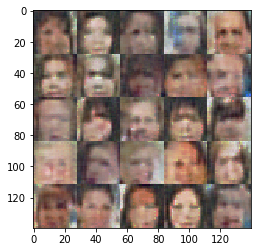

--------------------------------------------------------
Train Step: 3140
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 3.76133e-01, Max |Grad|: 2.85586e-02, Min |Grad|: 0.00000e+00, Mean: -8.24974e-06, Std: 5.28755e-04
G_Grad - Norm: 9.26020e-02,  Max |Grad|: 1.68467e-02, Min |Grad|: 5.64599e-13, Mean: -2.69773e-07, Std: 7.45916e-05
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.5846
--------------------------------------------------------
Train Step: 3160
Batch Size: 128, Learning Rate: 1e-05
D_Grad - Norm: 2.85316e-01, Max |Grad|: 3.02994e-02, Min |Grad|: 3.63798e-12, Mean: 1.04044e-05, Std: 4.00977e-04
G_Grad - Norm: 7.45481e-02,  Max |Grad|: 1.28409e-02, Min |Grad|: 0.00000e+00, Mean: 5.24771e-08, Std: 6.00495e-05
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.5874
Image: 79


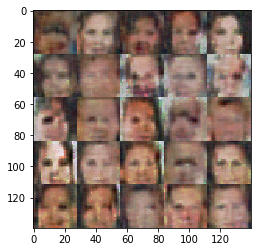

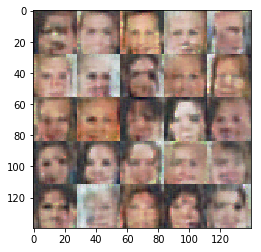

In [79]:
batch_size = 128
z_dim = 200
learning_rate = 0.001
beta1 = 0.1
alpha = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.